# **Assignment in Advanced Data Analysis for Management Support Summer 2020**

**Author: Svenja Fluhrer**

**Introduction**

Data science enables us to extract knowledge and insights from  different types of data. Given the increase in textual data which is available on the internet/social media and the possibility to scrap those data resources, Natural Language Processing (NLP) is a growing field in data science. NLP allows us to use features from text and word embeddings in our computations and algorithms.
The database for this regression task are blog articles which were posted on medium.com, a widely used platform for data science knowledge exchange. In this notebook, we will utilize text data and provided and generated meta data to predict the number of *Claps* (equivalent to *Likes*) an article receives. To solve this regression task we will (1) preprocess the data, both, the text and the meta data, (2) extract some additional features from the data, including features that require some more elaborated approaches, for instance topic modeling, (3) apply GloVe embeddings to our text data and, eventually, train neural networks. Our first neural network will be only trained beased on the non-text features and our final model will have mixed inputs, including the word embedding. With our final model we will (4) make predictions of the number of Claps the articles in our test set receive. Eventually, we will (5) conclude and summarize our learnings.

**Figure 1: Workflow**

![alt text](https://drive.google.com/uc?export=view&id=1K39gos5xzHoD824HWbpkTdy_0fM9cn0F)

**Table of Contents**

1. Text Cleaning and Preprocessing
2. Feature Engineering

  2.1 Meta features

  2.2 Dictionary based Sentiment Analyser

  2.3 Bag of Words based features

  2.4 Topic modeling with Word2Vec

3. Neural Network Modeling

  3.1 Basic model

  3.2 Mixed input model

4. Predictions

  4.1 Preparation of prediction dataset

  4.2 Prediction and submission preparation

5. Conclusion

References

Appendix


# 1. Text Cleaning and Preprocessing

In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string

#NLP
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import spacy
from bs4 import BeautifulSoup # Library beatifulsoup4 handles html
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

# Saving and loaded objects
import pickle

#VON HIER AN NOCH ÜBERSCHRIFTEN UND MODULE ZUORDNEN
# Load/save data from/to disk 
#import pickle




#NN
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import Conv1D, GlobalMaxPool1D, Dropout, concatenate
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')
path="/content/drive/My Drive/ADAMS_NLPtask_SS20/ADAMS_NLPtask_SS20/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [162]:
# load data training set
df = pd.read_csv(path + "Train.csv")
# load data test/prediction set
df_test = pd.read_csv(path + "Test.csv")

In [6]:
df.head()

,audioVersionDurationSec,codeBlock,codeBlockCount,collectionId,createdDate,createdDatetime,firstPublishedDate,firstPublishedDatetime,imageCount,isSubscriptionLocked,language,latestPublishedDate,latestPublishedDatetime,linksCount,postId,readingTime,recommends,responsesCreatedCount,socialRecommendsCount,subTitle,tagsCount,text,title,totalClapCount,uniqueSlug,updatedDate,updatedDatetime,url,vote,wordCount,publicationdescription,publicationdomain,publicationfacebookPageName,publicationfollowerCount,publicationname,publicationpublicEmail,publicationslug,publicationtags,publicationtwitterUsername,tag_name,slug,name,postCount,author,bio,userId,userName,usersFollowedByCount,usersFollowedCount,scrappedDate
0,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,en,2018-09-18,2018-09-18 20:58:20,1,10007d3018fe,0.958491,2,0,0,A major private IT company implements blockcha...,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100,private-business-government-and-blockchain-100...,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-go...,False,201,ICOBox is the first and the biggest new genera...,NaN,icobox.io,NaN,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",icobox_io,Blockchain,blockchain,Blockchain,265164.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
1,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,en,2018-09-18,2018-09-18 20:58:20,1,10007d3018fe,0.958491,2,0,0,A major private IT company implements blockcha...,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100,private-business-government-and-blockchain-100...,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-go...,False,201,ICOBox is the first and the biggest new genera...,NaN,icobox.io,NaN,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",icobox_io,Samsung,samsung,Samsung,5708.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
2,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,en,2018-09-18,2018-09-18 20:58:20,1,10007d3018fe,0.958491,2,0,0,A major private IT company implements blockcha...,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100,private-business-government-and-blockchain-100...,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-go...,False,201,ICOBox is the first and the biggest new genera...,NaN,icobox.io,NaN,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",icobox_io,It,it,It,3720.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
3,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,en,2018-01-07,2018-01-07 17:18:38,24,1000c43bcb97,19.716981,0,0,0,Introduction,5,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),0,introduction-3-1000c43bcb97,2018-01-07,2018-01-07 17:18:39,https://medium.com/s/story/introduction-3-1000...,False,4854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Technology,technology,Technology,166125.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104
4,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,en,2018-01-07,2018-01-07 17:18:38,24,1000c43bcb97,19.716981,0,0,0,Introduction,5,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),0,introduction-3-1000c43bcb97,2018-01-07,2018-01-07 17:18:39,https://medium.com/s/story/introduction-3-1000...,False,4854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Robotics,robotics,Robotics,9103.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104


In [343]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279577 entries, 0 to 279576
Data columns (total 50 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   audioVersionDurationSec      279577 non-null  int64  
 1   codeBlock                    25179 non-null   object 
 2   codeBlockCount               279577 non-null  float64
 3   collectionId                 137878 non-null  object 
 4   createdDate                  279577 non-null  object 
 5   createdDatetime              279577 non-null  object 
 6   firstPublishedDate           279577 non-null  object 
 7   firstPublishedDatetime       279577 non-null  object 
 8   imageCount                   279577 non-null  int64  
 9   isSubscriptionLocked         279577 non-null  bool   
 10  language                     279577 non-null  object 
 11  latestPublishedDate          279577 non-null  object 
 12  latestPublishedDatetime      279577 non-null  object 
 13 

In [ ]:
# We can have a first look into our test set
df_test.head()
# In the following we make plenty of decisions how to prepare our training dataset. It turns out wise to make those decisions with a general understanding
# in mind to which extent our prediction test set differs from our training set. Nevertheless, in this notebook, explanatory data analysis and preprocessing
# of the prediction test set can be found for reasons of clarity in section 4 Predictions.

In [163]:
# dropping duplicates in the training set
df.drop_duplicates(subset ="postId", inplace = True)

In [164]:
df=df.dropna(subset=['title']) #it is only one article, therefore its missing does not contain information

In [165]:
# For simplicity, we convert our int variables of interest to float so that all numeric variables of interest are of type float
df['totalClapCount'] = df['totalClapCount'].astype(np.float64)
df['wordCount'] = df['wordCount'].astype(np.float64)
df['responsesCreatedCount'] = df['responsesCreatedCount'].astype(np.float64)
df['imageCount'] = df['imageCount'].astype(np.float64)

# We change all numeric variables from float64 to float 32 to reduce memory consumption
num_vars = df.select_dtypes(include=np.float64).columns
df[num_vars] = df[num_vars].astype(np.float32)

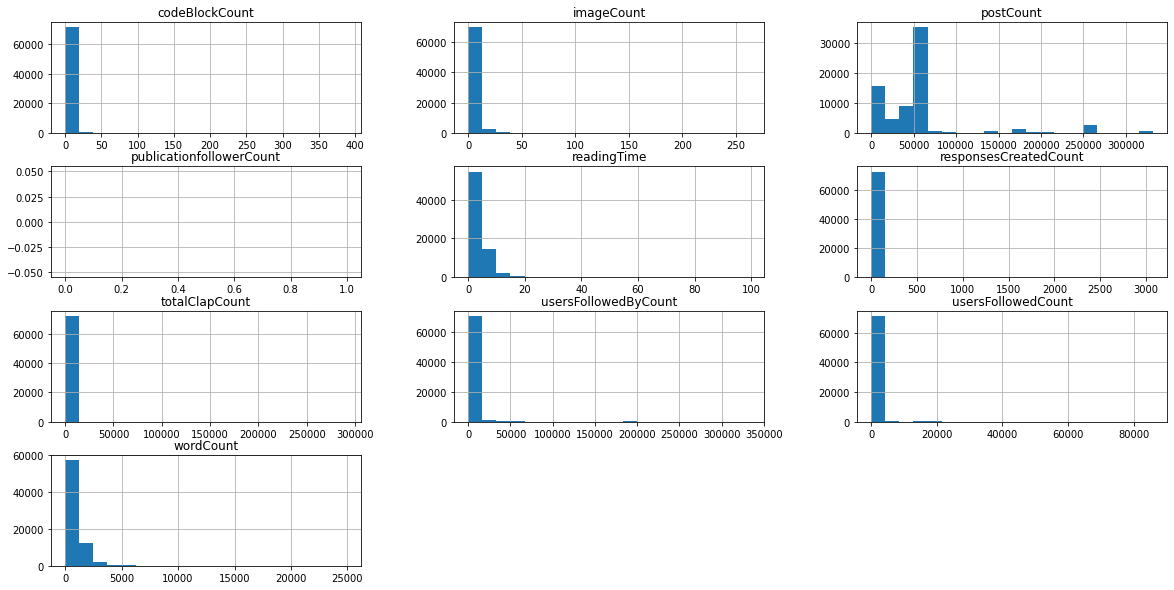

In [11]:
# Let us create some histograms to have a look on the distribution of our numeric variables
%matplotlib inline  
plt.rcParams["figure.figsize"] = (20,10)
df.select_dtypes(include='float32').hist(bins=20);

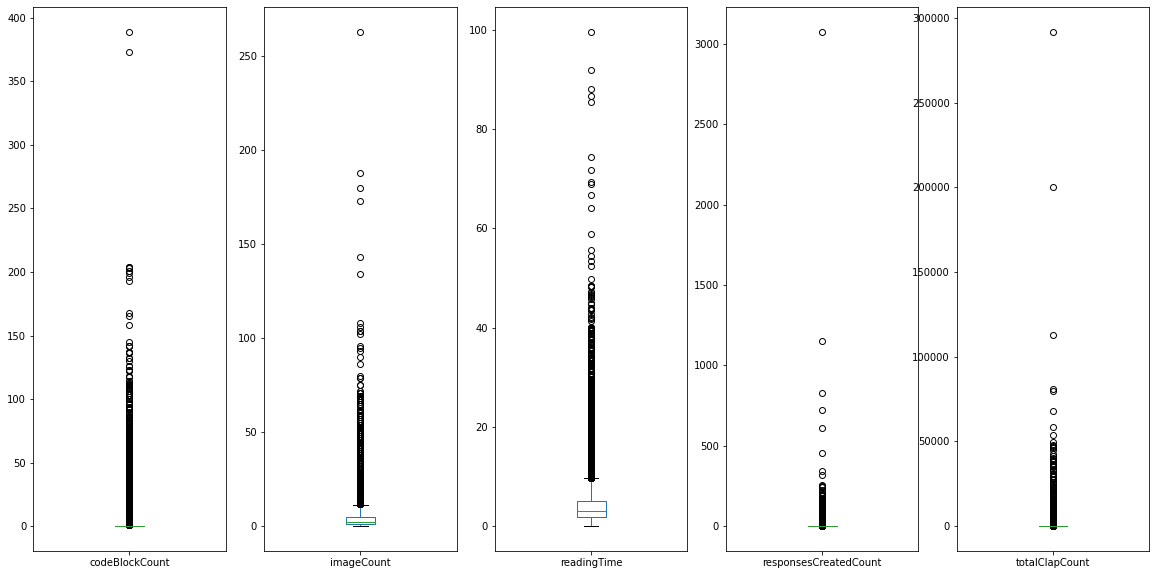

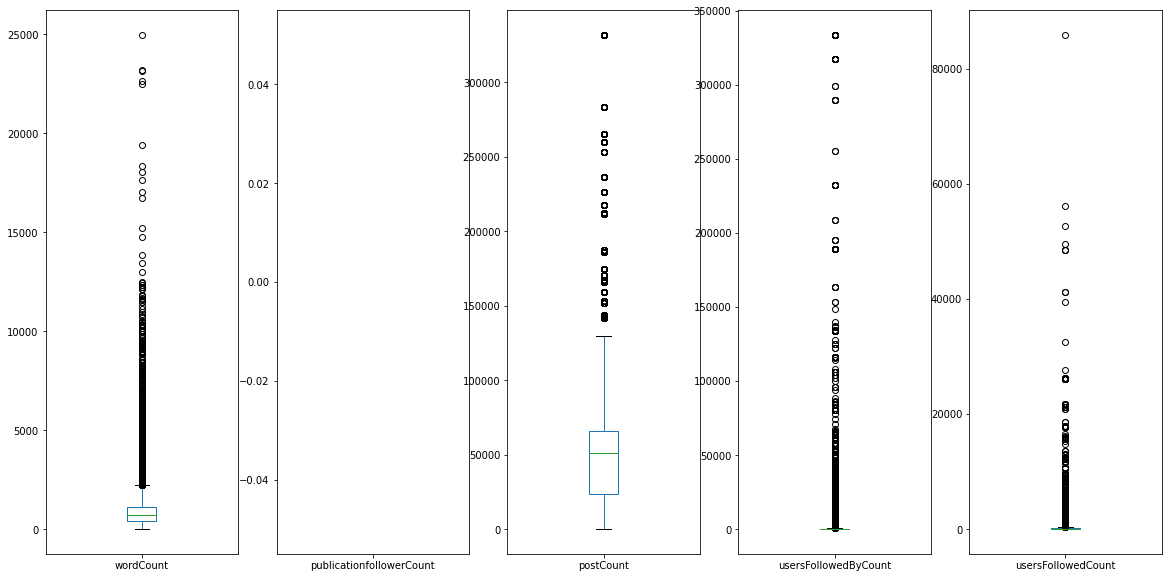

In [9]:
# Checking for outliers in our training set
num_vars = df.select_dtypes(include="float32")
half = np.ceil(num_vars.shape[1] / 2).astype(int)  # for cosmetic reasons we split the plots into two rows
num_vars.iloc[:, 0:half].plot(kind = 'box', subplots=True);
num_vars.iloc[:, half:num_vars.shape[1]].plot(kind = 'box', subplots=True);

In [381]:
df['responsesCreatedCount'].value_counts() #only few observations with many responses

0.0      60064
1.0       6045
2.0       2246
3.0       1062
4.0        646
         ...  
105.0        1
98.0         1
94.0         1
55.0         1
135.0        1
Name: responsesCreatedCount, Length: 139, dtype: int64

In [27]:
df.totalClapCount.describe()

count    72336.000000
mean        39.401527
std         55.734577
min          0.000000
25%          0.000000
50%          5.000000
75%         61.000000
max        152.500000
Name: totalClapCount, dtype: float64

In [166]:
num_cols = [x for x in df.columns if df[x].dtype == 'float32' and x not in ['responsesCreatedCount']]

In [167]:
# we first need our function to handle outliers 
# this code is adapted from Lessmann (2020a)
def outlier_truncation(x, factor=1.5):
    '''
    Identifies outlier values based on the inter-quartile range IQR. 
    Corresponding outliers are truncated and set to a value factor x IQR
    
        Parameters:
            x (Pandas Series): A data frame column to scan for outliers
            factor (float): An outlier is a value this many times the IQR above q3/below q1
            
        Returns:
            Adjusted variable in which outliers are truncated
    '''
    x_new = x
    
    # Calculate IQR
    IQR = x.quantile(0.75) - x.quantile(0.25) 
    
    # Define upper/lower bound
    upper = x.quantile(0.75) + factor*IQR
    lower = x.quantile(0.25) - factor*IQR
    
    # Truncation
    x_new[x < lower] = lower
    x_new[x > upper] = upper
    
    return x_new

In [168]:
#For responses we use another approach to loose less observations with non-zero responses. The fact that we have quite a different distribution
#of this variable with a prediction importance in the training and test set, is an issue we should keep in mind.
q = df['responsesCreatedCount'].quantile(0.97)
print(q)

5.0


In [169]:
df=df[df['responsesCreatedCount'] < q]

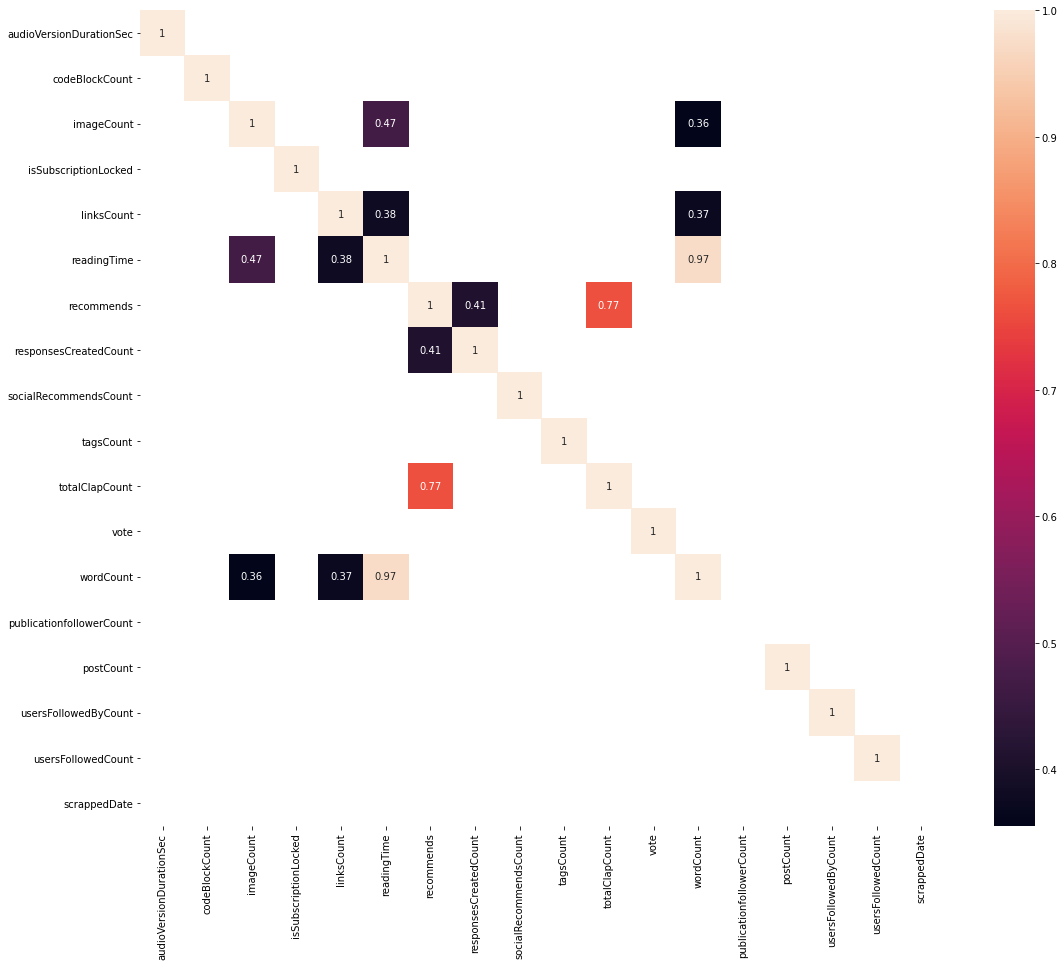

In [170]:
#we check some correlation between the numeric variables; of course we are especially interested in the correlation of our target variable with others
corr= df.corr()
f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr[(corr >= 0.30) | (corr <= -0.30)],
            annot=True);

# 2. Feature Engineering

**2.1 Meta features**

In [29]:
#Let us have a look at publicationname
df['publicationname'].value_counts()

Towards Data Science                                3249
Hacker Noon                                         1094
Becoming Human: Artificial Intelligence Magazine     739
Data Driven Investor                                 657
Chatbots Life                                        469
                                                    ... 
9indianews                                             1
NovaMining Italia                                      1
IWORKTECH                                              1
Kindigo Cyberbullying Blog                             1
Mylyanyk Marko                                         1
Name: publicationname, Length: 6414, dtype: int64

In [30]:
df['publication_counts'] = df.publicationname.groupby(df.publicationname).transform('count')

In [31]:
df['publication_counts']

0            2.0
3            NaN
7            NaN
11           1.0
16           NaN
           ...  
279557    3249.0
279562       9.0
279567    1094.0
279570      85.0
279572       4.0
Name: publication_counts, Length: 70063, dtype: float64

In [32]:
# We only consider publication names that appear more than 50 times
def g(row):
    if row['publication_counts'] <= 50:
        val = np.nan
    else:
        val = row['publicationname']
    return val

In [33]:
df['publicationname']=df.apply(g, axis=1)

In [34]:
def new_variables(data):
  # length of content
  data['len_text'] = data['text'].str.len()
  data['len_title'] = data['title'].str.len()

In [35]:
#create additional len features
new_variables(df)

Language: Our dataset which we will use for prediction, does have only  a few articles in any other language than English, therefore it makes sense to limit our training set to English articles only. This will also make NLP tasks much easier than working with text data in various languages.

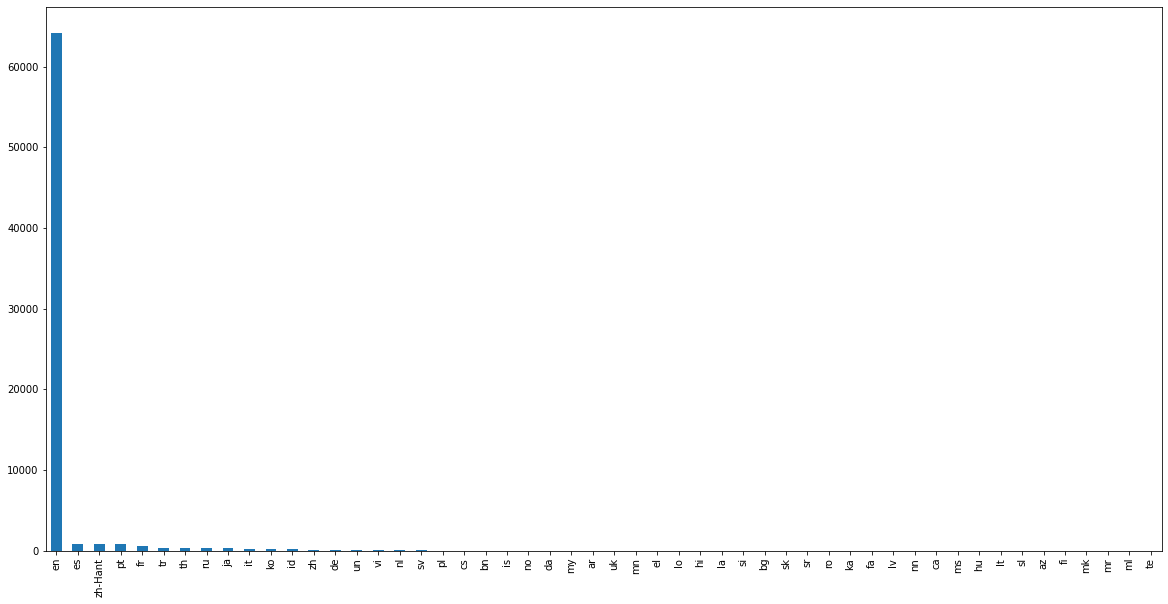

In [36]:
df['language'].value_counts().plot(kind='bar')

In [37]:
df=pd.get_dummies(df, columns=['language'])

In [38]:
df=df[(df.language_en !=0)]

In [39]:
len(df)

64151

In [40]:
# create feature how many days ago article was published
from datetime import datetime
now = datetime.now()
A = (now.strftime("%Y-%m-%d"))
date_format = "%Y-%m-%d"
A = datetime.strptime(A, date_format)
df['A']=A

df['createdDate'] = pd.to_datetime(df['createdDate'])

df['daysonline'] = df['A']- df['createdDate'] # even more precise would be till scrapping instead of till today
df['daysonline'] = pd.to_numeric(df['daysonline'].dt.days, downcast='integer')

In [41]:
# create feature day of the week article was first published
df['weekday']= df['createdDate'].apply(lambda x: x.weekday())

In [42]:
df['text_short'] = df['text'].astype(str).apply(lambda x: x[:5000])

In [43]:
# Lemmatize with POS Tag
def get_wordnet_pos(word):
    """Map POS tag to first character for lemmatization"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [44]:
# this code is adapted from Lessmann (2020b)
def clean_text(df):
    """ Standard NLP pre-processing chain including removal of html tags, non-alphanumeric characters, and stopwords.
        Words are subject to lemmatization using their POS tags, which are determind using WordNet. 
    """
    articles = []

    lemmatizer = WordNetLemmatizer()
    
    print('*' * 40)
    print('Cleaning {} text/title.'.format(df.shape[0]))
    counter = 0
    for article in df:
        
        # remove html content
        article_text = BeautifulSoup(article).get_text()
        
        # remove non-alphabetic characters
        article_text = re.sub("[^a-zA-Z]"," ", article_text)
    
        # tokenize the sentences
        words = word_tokenize(article_text.lower())
  
        # filter stopwords
        words = [w for w in words if w not in stopwords.words("english")]
        
        # lemmatize each word to its lemma
        lemma_words =[lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in words]
    
        articles.append(lemma_words)
              
        if (counter > 0 and counter % 500 == 0):
            print('Processed {} text/titles'.format(counter))
            
        counter += 1
        
    print('DONE')
    print('*' * 40)

    return(articles) 

In [45]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [46]:
# Do the cleaning
text = clean_text(df.text_short)

****************************************
Cleaning 64151 text/title.
Processed 500 text/titles
Processed 1000 text/titles
Processed 1500 text/titles
Processed 2000 text/titles
Processed 2500 text/titles
Processed 3000 text/titles
Processed 3500 text/titles
Processed 4000 text/titles
Processed 4500 text/titles
Processed 5000 text/titles
Processed 5500 text/titles
Processed 6000 text/titles
Processed 6500 text/titles
Processed 7000 text/titles
Processed 7500 text/titles
Processed 8000 text/titles
Processed 8500 text/titles
Processed 9000 text/titles
Processed 9500 text/titles
Processed 10000 text/titles
Processed 10500 text/titles
Processed 11000 text/titles
Processed 11500 text/titles
Processed 12000 text/titles
Processed 12500 text/titles
Processed 13000 text/titles
Processed 13500 text/titles
Processed 14000 text/titles
Processed 14500 text/titles
Processed 15000 text/titles
Processed 15500 text/titles
Processed 16000 text/titles
Processed 16500 text/titles
Processed 17000 text/titles


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://icoratingblog.wordpress.com/2017/12/07/ico-rating-2/

" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 25500 text/titles
Processed 26000 text/titles
Processed 26500 text/titles
Processed 27000 text/titles
Processed 27500 text/titles
Processed 28000 text/titles
Processed 28500 text/titles
Processed 29000 text/titles
Processed 29500 text/titles
Processed 30000 text/titles
Processed 30500 text/titles
Processed 31000 text/titles
Processed 31500 text/titles


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://icoratingblog.wordpress.com/2017/12/05/first-blog-post/

" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 32000 text/titles
Processed 32500 text/titles
Processed 33000 text/titles


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://blog.juecell.in/2018/08/artificial-intelligence-living-with.html?m=1
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 33500 text/titles
Processed 34000 text/titles
Processed 34500 text/titles
Processed 35000 text/titles
Processed 35500 text/titles
Processed 36000 text/titles
Processed 36500 text/titles
Processed 37000 text/titles
Processed 37500 text/titles
Processed 38000 text/titles
Processed 38500 text/titles
Processed 39000 text/titles


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://knowledgebuilderblog.wordpress.com/
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 39500 text/titles
Processed 40000 text/titles
Processed 40500 text/titles
Processed 41000 text/titles
Processed 41500 text/titles
Processed 42000 text/titles
Processed 42500 text/titles
Processed 43000 text/titles
Processed 43500 text/titles
Processed 44000 text/titles
Processed 44500 text/titles
Processed 45000 text/titles
Processed 45500 text/titles
Processed 46000 text/titles
Processed 46500 text/titles
Processed 47000 text/titles
Processed 47500 text/titles
Processed 48000 text/titles
Processed 48500 text/titles
Processed 49000 text/titles
Processed 49500 text/titles
Processed 50000 text/titles
Processed 50500 text/titles
Processed 51000 text/titles
Processed 51500 text/titles
Processed 52000 text/titles
Processed 52500 text/titles


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://icoratingblog.wordpress.com/2017/12/07/ico-rating-3/

" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 53000 text/titles
Processed 53500 text/titles
Processed 54000 text/titles
Processed 54500 text/titles
Processed 55000 text/titles
Processed 55500 text/titles
Processed 56000 text/titles
Processed 56500 text/titles
Processed 57000 text/titles
Processed 57500 text/titles
Processed 58000 text/titles
Processed 58500 text/titles
Processed 59000 text/titles
Processed 59500 text/titles
Processed 60000 text/titles
Processed 60500 text/titles
Processed 61000 text/titles
Processed 61500 text/titles
Processed 62000 text/titles
Processed 62500 text/titles
Processed 63000 text/titles
Processed 63500 text/titles
Processed 64000 text/titles
DONE
****************************************


In [47]:
title = clean_text(df.title)

****************************************
Cleaning 64151 text/title.
Processed 500 text/titles


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=l45iOR_JlUA" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 1000 text/titles
Processed 1500 text/titles
Processed 2000 text/titles
Processed 2500 text/titles
Processed 3000 text/titles
Processed 3500 text/titles
Processed 4000 text/titles
Processed 4500 text/titles
Processed 5000 text/titles
Processed 5500 text/titles
Processed 6000 text/titles
Processed 6500 text/titles
Processed 7000 text/titles
Processed 7500 text/titles
Processed 8000 text/titles
Processed 8500 text/titles
Processed 9000 text/titles


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.theaustralian.com.au/business/technology/opinion/the-gifts-ai-and-machine-learning-delive…" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 9500 text/titles
Processed 10000 text/titles
Processed 10500 text/titles
Processed 11000 text/titles
Processed 11500 text/titles
Processed 12000 text/titles
Processed 12500 text/titles
Processed 13000 text/titles
Processed 13500 text/titles
Processed 14000 text/titles
Processed 14500 text/titles
Processed 15000 text/titles
Processed 15500 text/titles
Processed 16000 text/titles
Processed 16500 text/titles
Processed 17000 text/titles
Processed 17500 text/titles
Processed 18000 text/titles
Processed 18500 text/titles
Processed 19000 text/titles


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://machinelearningtub.blogspot.com/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 19500 text/titles
Processed 20000 text/titles
Processed 20500 text/titles
Processed 21000 text/titles
Processed 21500 text/titles
Processed 22000 text/titles
Processed 22500 text/titles


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://youtu.be/LhWt0Oigt3o" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 23000 text/titles
Processed 23500 text/titles
Processed 24000 text/titles
Processed 24500 text/titles
Processed 25000 text/titles


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://icoratingblog.wordpress.com/2017/12/07/ico-rating-2/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 25500 text/titles
Processed 26000 text/titles
Processed 26500 text/titles
Processed 27000 text/titles


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://acadgild.com/blog/data-scientist-description" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 27500 text/titles
Processed 28000 text/titles
Processed 28500 text/titles
Processed 29000 text/titles
Processed 29500 text/titles
Processed 30000 text/titles
Processed 30500 text/titles
Processed 31000 text/titles
Processed 31500 text/titles


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://icoratingblog.wordpress.com/2017/12/05/first-blog-post/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 32000 text/titles
Processed 32500 text/titles
Processed 33000 text/titles


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://blog.juecell.in/2018/08/artificial-intelligence-living-with.html?m=1" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 33500 text/titles
Processed 34000 text/titles
Processed 34500 text/titles
Processed 35000 text/titles
Processed 35500 text/titles
Processed 36000 text/titles
Processed 36500 text/titles
Processed 37000 text/titles
Processed 37500 text/titles
Processed 38000 text/titles
Processed 38500 text/titles
Processed 39000 text/titles


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://knowledgebuilderblog.wordpress.com/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 39500 text/titles
Processed 40000 text/titles
Processed 40500 text/titles
Processed 41000 text/titles
Processed 41500 text/titles
Processed 42000 text/titles
Processed 42500 text/titles
Processed 43000 text/titles
Processed 43500 text/titles
Processed 44000 text/titles
Processed 44500 text/titles
Processed 45000 text/titles


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.order4trial.com/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.xploree.com/newsletters/april2018/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 45500 text/titles
Processed 46000 text/titles
Processed 46500 text/titles
Processed 47000 text/titles
Processed 47500 text/titles


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://smartceo.co/while-you-were-typing/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 48000 text/titles
Processed 48500 text/titles
Processed 49000 text/titles
Processed 49500 text/titles


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.gobeyond.ai/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 50000 text/titles
Processed 50500 text/titles
Processed 51000 text/titles
Processed 51500 text/titles


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.bigdataguys.com/Training/deep-learning-tensorflow-projects/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 52000 text/titles
Processed 52500 text/titles


/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://icoratingblog.wordpress.com/2017/12/07/ico-rating-3/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 53000 text/titles
Processed 53500 text/titles
Processed 54000 text/titles
Processed 54500 text/titles
Processed 55000 text/titles
Processed 55500 text/titles
Processed 56000 text/titles
Processed 56500 text/titles
Processed 57000 text/titles
Processed 57500 text/titles
Processed 58000 text/titles
Processed 58500 text/titles
Processed 59000 text/titles
Processed 59500 text/titles
Processed 60000 text/titles
Processed 60500 text/titles
Processed 61000 text/titles
Processed 61500 text/titles
Processed 62000 text/titles
Processed 62500 text/titles
Processed 63000 text/titles
Processed 63500 text/titles
Processed 64000 text/titles
DONE
****************************************


In [48]:
# Undo the tokenization and put the data into a new column in the data frame.
from nltk.tokenize.treebank import TreebankWordDetokenizer

df['text'] = [TreebankWordDetokenizer().detokenize(word) for word in text]
df['title'] = [TreebankWordDetokenizer().detokenize(wrd) for wrd in title]

**2.2 Dictionary based Sentiment Analyser**

In [49]:
# We conduct a simple dictionary based sentiment anlysis by using the the package Blob  
from textblob import TextBlob
# Defining a sentiment analyser function
def sentiment_analyser(text):
    return text.apply(lambda Text: pd.Series(TextBlob(Text).sentiment.polarity))

# Applying function to reviews
df['Polarity'] = sentiment_analyser(df['text'])

In [50]:
# Store dataframe to disk
file_name = 'df_0823.pkl'
df.to_pickle(path + file_name)

In [3]:
# Load dataframe from disk
file_name = 'df_0823.pkl'
df = pd.read_pickle(path + file_name)

**2.3 Bag of Words based features**

In [4]:
#splitting into train and test data
x_train, x_test, y_train, y_test = train_test_split(df, np.ravel(df.totalClapCount), test_size=0.2, random_state=42)

In [5]:
# Function to count words
# This code is adapted from a kaggle post by Hsankesara (2018)
def get_words_count(df, col):
    words_count = {}
    m = df.shape[0]
    for i in range(m):
        words = df[col].iat[i].split()
        for word in words:
            if word.lower() in words_count:
                words_count[word.lower()] += 1
            else:
                words_count[word.lower()] = 1
    return words_count

In [6]:
title_words = get_words_count(x_train, 'title')

text_words = get_words_count(x_train, 'text')

In [7]:
title_words_df = pd.DataFrame(list(title_words.items()), columns=['words', 'count'])

text_words_df = pd.DataFrame(list(text_words.items()), columns=['words', 'count'])

In [8]:
## List of 15 most frequent words occurred in title
title_words_df.sort_values(by='count', ascending=False).head(15)

,words,count
35,ai,8394
151,learn,6488
20,data,6032
150,machine,4442
50,intelligence,3591
49,artificial,3357
132,use,2487
21,science,1993
13,part,1826
273,deep,1591


<Figure size 600x400 with 0 Axes>

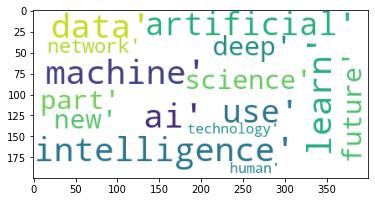

In [375]:
#Nicely displayed in a WordCloud
from wordcloud import WordCloud
fig = plt.figure(dpi=100)
a4_dims = (6, 12)
fig, ax = plt.subplots(figsize=a4_dims)
wordcloud = WordCloud(background_color ='white', max_words=200,max_font_size=40,random_state=3).generate(str(title_words_df.sort_values(by='count', ascending=False)['words'].values[:15]))
plt.imshow(wordcloud)
plt.title = 'Top Word in the title of Medium Articles'
plt.show()

In [376]:
## List of 15 most frequent words occurred in text
text_words_df.sort_values(by='count', ascending=False).head(15)

,words,count
172,data,235009
181,use,149626
141,learn,147307
95,ai,146450
849,machine,92860
503,make,87766
161,one,83464
1479,model,78784
296,time,78019
56,like,69431


In [9]:
top_title_words = title_words_df.sort_values(by='count', ascending=False)['words'].values[:15]
top_text_words = text_words_df.sort_values(by='count', ascending=False)['words'].values[:15]

In [10]:
## Count occurence of top fiveteen words in every title in dataframe
x_train['top_title_count'] = x_train['title'].apply(lambda s: sum(s.count(top_title_words[i]) for  i in range(15)))
x_train['top_text_count'] = x_train['text'].apply(lambda s: sum(s.count(top_text_words[i]) for  i in range(15)))

x_test['top_title_count'] = x_test['title'].apply(lambda s: sum(s.count(top_title_words[i]) for  i in range(15)))
x_test['top_text_count'] = x_test['text'].apply(lambda s: sum(s.count(top_text_words[i]) for  i in range(15)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

**2.4 Topic modeling with Word2Vec**

Topic models help us to explore the structure of our documents by clustering the articles based on the words that occur in them.

There are many different approaches to model topics. In this part, we will model topics based on Word2Vec. In the course of this, we will give a little introduction into Word2Vec. An alternative approach, namely Latent Dirichlet Allocation (LDA), applied to our data can be found in Appendix 1 (including very nice interactive topic visualization).

Word2vec consists of many two-layer neural networks (note: shallow not deep NN) that are trained to produce word embeddings. Word embeddings are vectors where words are represented as real-valued vector in the predefined vector space. As Word2vec captures the context of words, the word vectors are positioned in a way that words with shared context are located close to one another in the vector space (Goldberg & Levy 2014).

To produce word embeddings Word2vec can utilize two different model architectures: continuous bag-of-word model (CBOW) or skip-gram. The difference between CBOW and skip-gram is whether the context word is at the input layer (-> CBOW) or on the output layer (skip-gram) (Rong 2014).

Since it is supposed to be faster, we focus on Word2Vec with CBOW in this part.

![alt text](https://drive.google.com/uc?export=view&id=10jw4Pq6QJcAplGRGNqZECO7bvL1_agJL)

**Figure 2: CBOW model**

Source: Rong, 2014.

The vocabulary size is V, and the hidden layer size is N.
The input is a one-hot encoded vector, which means for a given input context word, only one units out of {x1,···,xV} will be 1. All other units are 0.
Between the input layer and the hidden layer as well as between the hidden layer and the output layer, there is a weight matrix W or W′. Each row of W is the N-dimension vector representation vw of the associated word of the input layer. Since we have more than one context word as input, to compute the hidden layer output, the CBOW model takes the average of the vectors of the input context words (Rong 2014).

In contrast to our final model, we will not draw on a pretrained model for this task. Instead we will build the model from scratch based on the vocubalary of our articles.


In [11]:
import numpy as np
import gensim
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

In [12]:
#Our yet empty corpus (= collection of text sources) needs to be fed with tokens
def tokenize(df):
    tokens = []
    for article in df:
        # tokenize the sentences
        words = word_tokenize(article.lower())
        tokens.append(words)
    return(tokens) 

In [ ]:
corpus = tokenize(x_train.text)

In [ ]:
#with the gensim library, we can construct our model
model = gensim.models.Word2Vec(corpus, size=100, window=3, min_count=50, sg=0, workers=4)
# Hyperparamters: size = dimensionality of the word , window = maximum distance between the current and predicted word within a sentence,
# min_count = ignores all words with total frequency lower than this, # sg = training algorithm - 1 for skip-gram; otherwise CBOW,
#workers = number of workers for multicore machine training

In [ ]:
#Let us see how well our model works
model.most_similar('big')

In [ ]:
model.most_similar('science')

First impression: Despite the relatively small size of the corpus, our model seems to work well. One last playing around with the model...

In [ ]:
print(model.most_similar(positive=['woman', 'king'], negative=['man'], topn=3)) #this is a famous example to show how Word2Vec works
#Now trying a new example:
print(model.most_similar(positive=['pen', 'code'], negative=['keyboard'], topn=3))

To better understand the spatiality of word embeddings, here is the explanation of what we just did: we started at the 'king'-vector, we added the 'woman'-vector and subtracted the 'man'-vector. The result are words with vectors close to the calculated vector.

In [ ]:
# Save w2v model
with open(path + 'modelw2v.pkl','wb') as file_name:
    pickle.dump(model, file_name)

In [13]:
# Load w2v model
with open(path + 'modelw2v.pkl','rb') as file_name:
    model = pickle.load(file_name)

In [382]:
print(u'{:,} terms in the word2vec vocabulary.'.format(len(model.wv.vocab)))

12,611 terms in the word2vec vocabulary.


In [14]:
#creating some helper dataframes
text_train = pd.DataFrame(x_train.text)
text_train.columns = ['text']

text_test = pd.DataFrame(x_test.text)
text_test.columns = ['text']

In [15]:
#creating a new class and entitle it with functions
class WordVecVectorizer(object):
    def __init__(self, model):
        self.model = model
        self.dim = 100    
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.model[w] for w in texts.split() if w in self.model]
                    or [np.zeros(self.dim)], axis=0)
            for texts in X
        ])

In [16]:
text_train.head()

,text
46809,real question physical digital divide get blur...
21524,k mean cluster pair selection python part seri...
49112,inspem list foxico project successfully list f...
34871,need know application data science term data s...
99128,entertainment industry benefit data science qu...


In [17]:
wtv_vect = WordVecVectorizer(model) #creating our word vector
X_train_wtv = wtv_vect.transform(text_train.text)
print(X_train_wtv.shape)

#for test data
X_test_wtv = wtv_vect.transform(text_test.text)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


(51320, 100)


In [386]:
X_train_wtv #that is how the word vectors look like

array([[ 6.54049367e-02,  5.13424315e-02, -2.21621007e-01, ...,
        -1.66640267e-01,  2.97954325e-02,  4.90585268e-01],
       [-5.52853763e-01, -7.25224093e-02, -6.31246209e-01, ...,
        -3.15115601e-01, -2.46876910e-01,  2.41931006e-01],
       [ 8.33659694e-02,  5.63420951e-01, -5.85730135e-01, ...,
         8.17540288e-01,  3.61274093e-01,  1.69470027e-01],
       ...,
       [-2.61955142e-01, -9.54550356e-02, -1.55759156e-01, ...,
        -1.03838570e-01,  2.32327249e-04,  3.82411003e-01],
       [ 6.99508190e-02, -1.77830756e-01, -1.54552057e-01, ...,
        -4.63827848e-02,  8.83894339e-02,  1.57165855e-01],
       [-4.73575711e-01,  3.57513607e-01, -1.40463158e-01, ...,
         4.38232243e-01,  4.38237906e-01,  4.42991376e-01]])

In [18]:
# now we need a method to cluster our vectors - we choose KMeans but it could be a different one, too
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=7, init='random', #we decide for 7 different topics
    n_init=10, max_iter=100, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X_train_wtv)
km_df = pd.DataFrame({'text' :text_train.text, 'topic_cluster' :y_km })


y_km_test = km.predict(X_test_wtv)
km_df_test = pd.DataFrame({'text' :text_test.text, 'topic_cluster' :y_km_test })

In [128]:
km_df_test.head()

,text,topic_cluster
30000,future humanity stay hungry stay human gerd le...,3
146258,pete kane svai community importance open datas...,4
4003,robot write blog post melissa chadwick weave w...,3
153753,connection artificial intelligence conversatio...,0
206115,reddit com r antisemitism unsupervised learn p...,5


In [19]:
# We want to have a look into the different topics we found
def get_top_n_words(corpus, n=10):
  vec = CountVectorizer(stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]



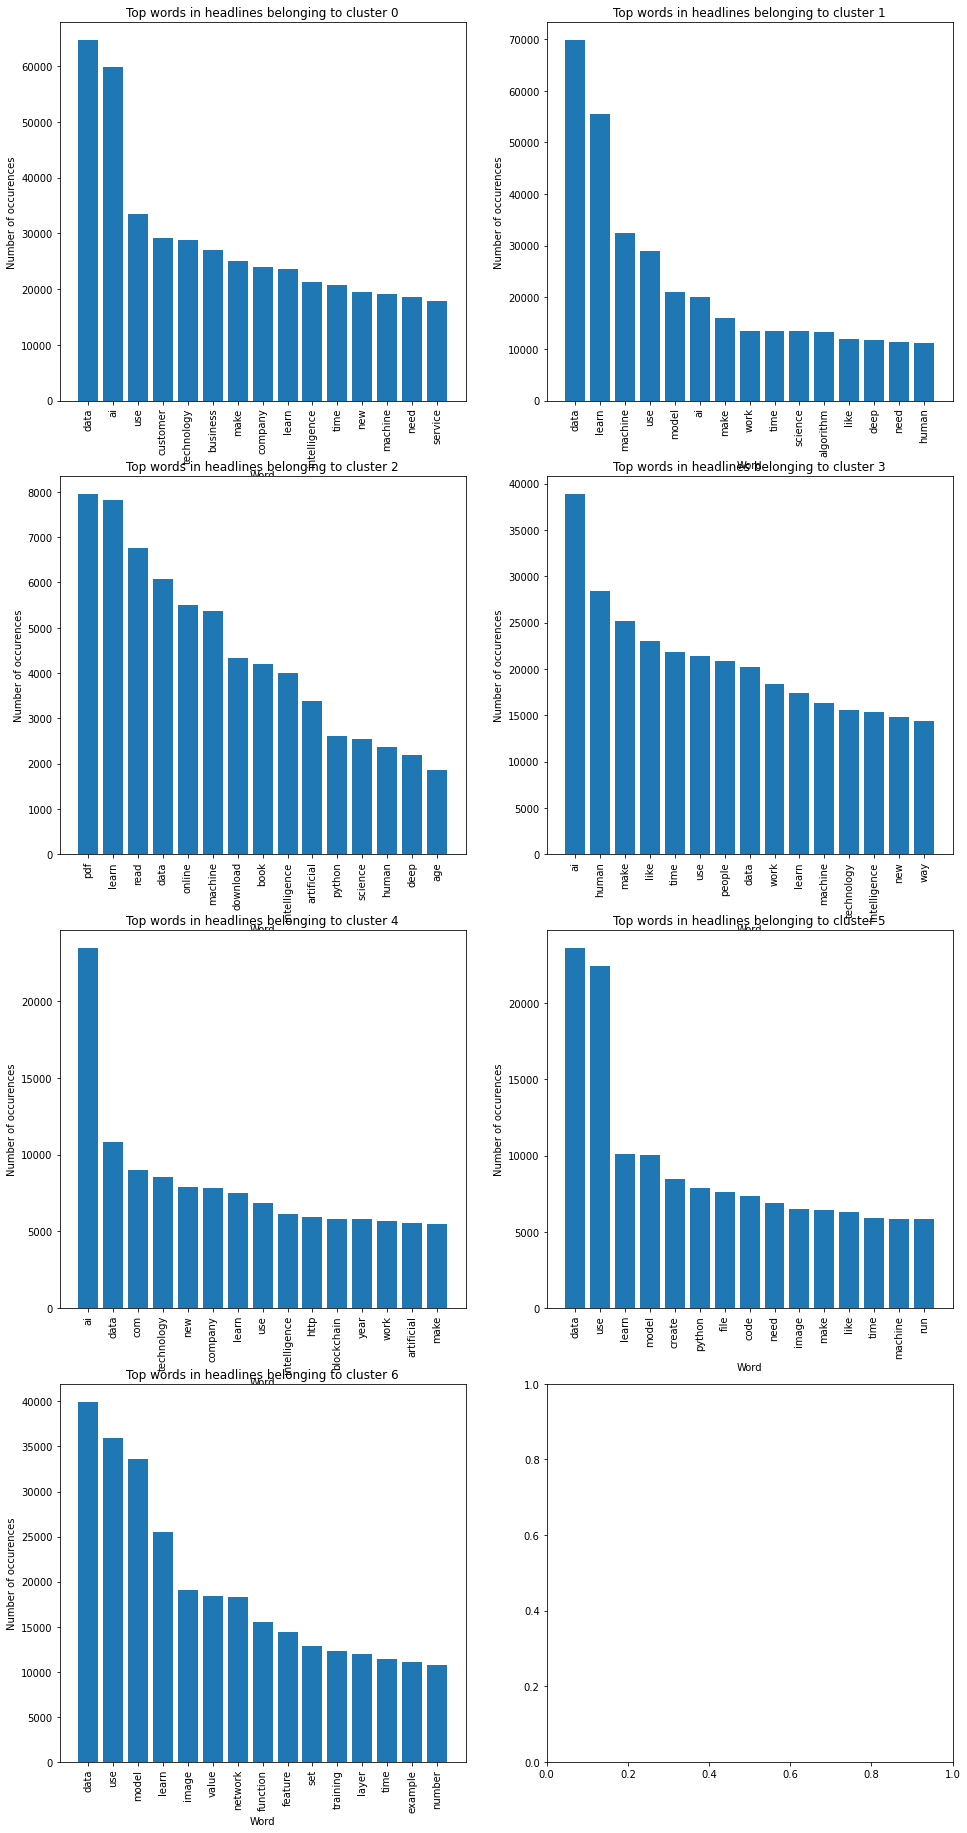

In [130]:
words = []
word_values = []
for i,j in get_top_n_words(km_df[km_df['topic_cluster'] == 0]['text'],15):
  words.append(i)
  word_values.append(j)

words1 = []
word_values1 = []
for i,j in get_top_n_words(km_df[km_df['topic_cluster'] == 1]['text'],15):
  words1.append(i)
  word_values1.append(j)

words2 = []
word_values2 = []
for i,j in get_top_n_words(km_df[km_df['topic_cluster'] == 2]['text'],15):
  words2.append(i)
  word_values2.append(j)

words3 = []
word_values3 = []
for i,j in get_top_n_words(km_df[km_df['topic_cluster'] == 3]['text'],15):
  words3.append(i)
  word_values3.append(j)

words4 = []
word_values4 = []
for i,j in get_top_n_words(km_df[km_df['topic_cluster'] == 4]['text'],15):
  words4.append(i)
  word_values4.append(j)

words5 = []
word_values5 = []
for i,j in get_top_n_words(km_df[km_df['topic_cluster'] == 5]['text'],15):
  words5.append(i)
  word_values5.append(j)

words6 = []
word_values6 = []
for i,j in get_top_n_words(km_df[km_df['topic_cluster'] == 6]['text'],15):
  words6.append(i)
  word_values6.append(j)

fig, axs = plt.subplots(4, 2, figsize=(16,32))
axs[0, 0].bar(range(len(words)), word_values);
axs[0, 0].set_xticks(range(len(words)));
axs[0, 0].set_xticklabels(words, rotation='vertical');
axs[0, 0].set_title('Top words in headlines belonging to cluster 0');
axs[0, 0].set_xlabel('Word');
axs[0, 0].set_ylabel('Number of occurences');
axs[0, 1].bar(range(len(words1)), word_values1);
axs[0, 1].set_xticks(range(len(words1)));
axs[0, 1].set_xticklabels(words1, rotation='vertical');
axs[0, 1].set_title('Top words in headlines belonging to cluster 1');
axs[0, 1].set_xlabel('Word');
axs[0, 1].set_ylabel('Number of occurences');
axs[1, 0].bar(range(len(words2)), word_values2);
axs[1, 0].set_xticks(range(len(words1)));
axs[1, 0].set_xticklabels(words2, rotation='vertical');
axs[1, 0].set_title('Top words in headlines belonging to cluster 2');
axs[1, 0].set_xlabel('Word');
axs[1, 0].set_ylabel('Number of occurences');
axs[1, 1].bar(range(len(words3)), word_values3);
axs[1, 1].set_xticks(range(len(words3)));
axs[1, 1].set_xticklabels(words3, rotation='vertical');
axs[1, 1].set_title('Top words in headlines belonging to cluster 3');
axs[1, 1].set_xlabel('Word');
axs[1, 1].set_ylabel('Number of occurences');
axs[2, 0].bar(range(len(words4)), word_values4);
axs[2, 0].set_xticks(range(len(words4)));
axs[2, 0].set_xticklabels(words4, rotation='vertical');
axs[2, 0].set_title('Top words in headlines belonging to cluster 4');
axs[2, 0].set_xlabel('Word');
axs[2, 0].set_ylabel('Number of occurences');
axs[2, 1].bar(range(len(words5)), word_values5);
axs[2, 1].set_xticks(range(len(words5)));
axs[2, 1].set_xticklabels(words5, rotation='vertical');
axs[2, 1].set_title('Top words in headlines belonging to cluster 5');
axs[2, 1].set_xlabel('Word');
axs[2, 1].set_ylabel('Number of occurences');
axs[3, 0].bar(range(len(words6)), word_values6);
axs[3, 0].set_xticks(range(len(words6)));
axs[3, 0].set_xticklabels(words6, rotation='vertical');
axs[3, 0].set_title('Top words in headlines belonging to cluster 6');
axs[3, 0].set_xlabel('Word');
axs[3, 0].set_ylabel('Number of occurences');
plt.show()


Even though there are some overlaps, it is possible to identify how the 6 clusters differ from each other (e.g. type of data, practice-oriented vs. news-oriented etc.)

In [20]:
x_train['topic_w2v']=km_df['topic_cluster']

x_test['topic_w2v']=km_df_test['topic_cluster']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# 3. Neural Network Modeling

In [21]:
# Before we start with our basic model, we limit our dataframe to the final input features
x_train1=x_train[['responsesCreatedCount', 'len_text', 'imageCount', 'len_title','daysonline', 'top_title_count', 'top_text_count', 'publicationname', 'weekday','Polarity', 'topic_w2v']]

x_test1=x_test[['responsesCreatedCount', 'len_text', 'imageCount','len_title','daysonline', 'top_title_count', 'top_text_count', 'publicationname', 'weekday', 'Polarity', 'topic_w2v']]

In [22]:
cat_columns = ['topic_w2v',  'publicationname', 'weekday']

In [23]:
x_train1 = pd.get_dummies(x_train1, prefix_sep="__",
                              columns=cat_columns)

In [24]:
#We create the dummies in the validation set based on the dummies of the training set
cat_dummies = [col for col in x_train1 
               if "__" in col 
               and col.split("__")[0] in cat_columns]

In [25]:
x_test1 = pd.get_dummies(x_test1, prefix_sep="__", 
                                   columns=cat_columns)

In [26]:
# Remove additional columns
for col in x_test1.columns:
    if ("__" in col) and (col.split("__")[0] in cat_columns) and col not in cat_dummies:
        print("Removing additional feature {}".format(col))
        x_test1.drop(col, axis=1, inplace=True)

In [27]:
for col in cat_dummies:
    if col not in x_test1.columns:
        print("Adding missing feature {}".format(col))
        x_test1[col] = 0

Adding missing feature publicationname__Planeta Chatbot : todo sobre los Chatbots y la Inteligencia Artificial


Next, we standardize all features with StandardScaler(). The mean of each variable is subtracted and the values are divided by the standard deviation.
Standardization is important since the NN-models are sensitive to unstandardized features.


In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train1)#mind that we use only x_train values not to leak the data to the test set
x_train1= scaler.transform(x_train1)
x_test1= scaler.transform(x_test1) 

**3.1 Basic model**

**- Other features, without word embedding as input**

First, we build a model based on our meta features and the features we extracted in earlier steps from the text data. (See Appendix 2 for a model without any features generated from the text data.) Our model is a deep neural network with four layers: an input layer, two hidden layers and an output layer. Each hidden unit and each output unit is connected to every unit in the layers either side. The hidden layers use a nonlinear activation function. Since we conduct a regression with a continuouse output, the output layer uses a linear activation function which, therefore, is a linear function of its inputs
(Zhang et al., n.d; Zupan, 2003: 200-206).

**Figure 3: Simplified depiction of deep neural network**
![alt text](https://drive.google.com/uc?export=view&id=1_7qoQ81PDL6PmBI44dZ0QUp5YpkEix5Q)

[created with tool http://alexlenail.me/NN-SVG/index.html ]


In [39]:
from keras.models import Sequential
from keras.layers import Dense, Embedding,GRU, Dropout
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Embedding,LSTM,Dense
from keras.layers import Bidirectional

from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors


In [40]:
# Some variables to centralize the configuration of deep learning models
# Hyperparametertuning for this model can be found in Appendix 3
EPOCH = 30
EMBEDDING_DIM = 50
BATCH_SIZE=32
VAL_SPLIT = 0.25

In [41]:
dim=x_train1.shape[1]

In [42]:
model_ofeatures = Sequential() #otherfeatures 
model_ofeatures.add(Dense(32, input_dim=dim, activation="relu"))
model_ofeatures.add(Dense(8, activation="relu"))
model_ofeatures.add(Dense(1, kernel_initializer='normal', activation='linear'))
model_ofeatures.compile(loss='mean_absolute_error', optimizer='adam', metrics='mse')
model_ofeatures.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                2272      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 2,545
Trainable params: 2,545
Non-trainable params: 0
_________________________________________________________________


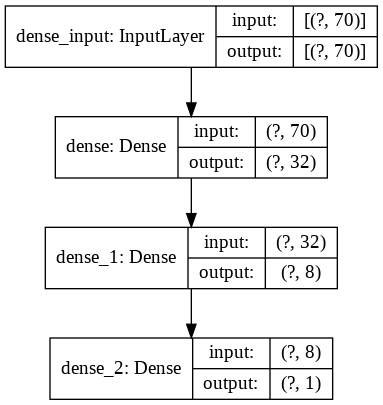

In [43]:
from keras.utils import plot_model
plot_model(model_ofeatures, to_file='model_plotof.png', show_shapes=True, show_layer_names=True)

In [44]:
# early stopping as one form of regularization to avoid overfitting
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

Before we start fitting our model. Let us summarize what occurs while our code is running. Our neural network learning works by forward- and backpropagation:

1. Forward propagation: The inputs are passed through the neural network. The inputs are multiplied by the initially given weights of each layer, bias are added and the the activation function is applied to the neurons. Eventually an output is generated. 

2. Backpropagation: An error function is defined, which captures the delta between the correct output and the actual output of the model. In order to minimize the error function, the weights of the connections between the units in the network are modified. The weights are updated according to the results of the backpropagation algorithm

(Zhang et al., n.d; Zupan, 2003: 200-206).


 

In [45]:
model_ofeat_story = model_ofeatures.fit(x_train1, y_train, batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=VAL_SPLIT, callbacks=[early])

Epoch 1/30
1203/1203 [==============================] - 4s 3ms/step - loss: 65.8748 - mse: 134602.8125 - val_loss: 65.9436 - val_mse: 90276.0938
Epoch 2/30
1203/1203 [==============================] - 3s 3ms/step - loss: 62.5555 - mse: 130843.7344 - val_loss: 65.6885 - val_mse: 90148.5312
Epoch 3/30
1203/1203 [==============================] - 3s 3ms/step - loss: 62.3333 - mse: 130490.2266 - val_loss: 65.6635 - val_mse: 90210.3672
Epoch 4/30
1203/1203 [==============================] - 3s 2ms/step - loss: 62.2113 - mse: 130470.1719 - val_loss: 65.6175 - val_mse: 90283.7109
Epoch 5/30
1203/1203 [==============================] - 3s 2ms/step - loss: 62.1096 - mse: 130288.7812 - val_loss: 65.5965 - val_mse: 90289.0078
Epoch 6/30
1203/1203 [==============================] - 3s 2ms/step - loss: 62.0384 - mse: 130317.6094 - val_loss: 65.6020 - val_mse: 90254.1250
Epoch 00006: early stopping


In [46]:
SCORE_BAG = {}  # Dictionary to store the results of different Keras models
def eval (model, story, x_ts, y_ts, cut_off=0.5):
  score = model.evaluate(x_ts, y_ts, verbose=0)
  return score

In [47]:
evalu=eval(model_ofeatures, model_ofeat_story, x_test1, y_test)

In [48]:
SCORE_BAG.update({'ofeatures' : eval(model_ofeatures, model_ofeat_story, x_test1, y_test)})

In [50]:
SCORE_BAG

{'ofeatures': [67.50244903564453, 50127.31640625]}

**3.2 Mixed input model**

We want to combine meta information and textual information as input to our model. We build two submodels. One with the features as in the Basic Model and another one with pre-trained GloVe word embeddings applied to our text data as input. We concatenate the output from the first submodel with the output from the second submodel.

We use pre-trained embeddings which were trained on a big corpus - pretrained GloVe embeddings. We first have to load it and create the embedding matrix. Then we can continue with setting the embedding layer.  Since we have the full sentences of our articles available, we can employ a bidirectional NLP model. The bidirectional GRU takes the left and the right context of a word in consideration by introducing a bidirectional layer. The GRU has fewer parameters than its alternative long short-term memory (LSTM) and therefore, performs faster. The input to the GRU model are the word embeddings, which we obtain from the Keras Embedding layer.


Wang et al (2019) display an example of an bidirectional GRU model as following:

**Figure 4: Bidirectional feature extraction**

![alt text](https://drive.google.com/uc?export=view&id=1Use0XZZ7bYF1EqAPhGG_eG8TwPKK_dt8)


Please find an overview and comparison of alternative Neural Networks models with a word embedding as input in Appendix 4.

In [51]:
# Build vocabulary using Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

First, we need to prepare our word embeddings. For these steps code by Lessmann (2020b) was adapted and modified.

In [30]:
NUM_WORDS = 2500

tokenizer_obj = Tokenizer(NUM_WORDS, oov_token=1)  # We fit the tokenizer to the training set articles. The test set might include
tokenizer_obj.fit_on_texts(x_train.text)  # words that are not part of the training data. The argument oov_token ensures that such new words are mapped to the specified index

In [31]:
# Convert training set articles to sequences of integer values
X_tr_int = tokenizer_obj.texts_to_sequences(x_train.text)

In [32]:
#* Determine the maximum article length in the training set
max_article_length = max([len(article) for article in X_tr_int])
print('The longest article of the training set has {} words.'.format(max_article_length))

The longest article of the training set has 1118 words.


In [33]:
# Upper bound of the article length for padding
MAX_ARTICLE_LENGTH = 500

X_tr_int_pad = pad_sequences(X_tr_int, MAX_ARTICLE_LENGTH)

In [34]:
#apply to test dataset

# Encode and pad the test data
X_ts_int = tokenizer_obj.texts_to_sequences(x_test.text)  # Due to oov_token argument, new words will be mapped to 1
X_ts_int_pad = pad_sequences(X_ts_int, MAX_ARTICLE_LENGTH)

In [35]:
# Structure of the prepared training and test data
X_tr_int_pad.shape, y_train.shape, X_ts_int_pad.shape, y_test.shape

((51320, 500), (51320,), (12831, 500), (12831,))

In [36]:
# Load GloVe embeddings
glove_index = {}
with open(path + 'glove.6B.50d.txt', 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_index[word] = coefs

print('Found %s word vectors.' % len(glove_index))

Found 400000 word vectors.


In [37]:
def get_embedding_matrix(tokenizer, pretrain, vocab_size):
    '''
        Helper function to construct an embedding matrix for 
        the focal corpus based on some pre-trained embeddings.
    '''
    
    dim = 0
    if isinstance(pretrain, KeyedVectors) or isinstance(pretrain, Word2VecKeyedVectors):
        dim = pretrain.vector_size        
    elif isinstance(pretrain, dict):
        dim = next(iter(pretrain.values())).shape[0]  # get embedding of an arbitrary word
    else:
        raise Exception('{} is not supported'.format(type(pretrain)))
    
    
    # Initialize embedding matrix
    emb_mat = np.zeros((vocab_size, dim))

    # There will be some words in our corpus for which we lack a pre-trained embedding. (See Appendix 5 code how to compute the coverage rate of the pretrained mebedding)
    # In this tutorial, we will simply use a vector of zeros for such words. We also keep
    # track of the words to do some debugging if needed
    oov_words = []
    # Below we use the tokenizer object that created our task vocabulary. This is crucial to ensure
    # that the position of a words in our embedding matrix corresponds to its index in our integer
    # encoded input data
    for word, i in tokenizer.word_index.items():  
        # try-catch together with a zero-initilaized embedding matrix achieves our rough fix for oov words
        try:
            emb_mat[i] = pretrain[word]
        except:
            oov_words.append(word)
    print('Created embedding matrix of shape {}'.format(emb_mat.shape))
    print('Encountered {} out-of-vocabulary words.'.format(len(oov_words)))
    return (emb_mat, oov_words)

In [52]:
# Create matrix with Glove embeddings
glove_weights, _ = get_embedding_matrix(tokenizer_obj, glove_index, NUM_WORDS)

Created embedding matrix of shape (2500, 50)
Encountered 152707 out-of-vocabulary words.


Time to build the model architecture. For this task code by Usman (2020) was adapted and modified.

In [53]:
#we have two inputs
input_1 = Input(shape=(MAX_ARTICLE_LENGTH,))

input_2 = Input(shape=(70,))

In [54]:
# submodel embedding layer
embedding_layer = Embedding(NUM_WORDS, 
                         EMBEDDING_DIM,  
                         embeddings_initializer=Constant(glove_weights), 
                         input_length=MAX_ARTICLE_LENGTH, 
                         trainable=False
                         ) (input_1)
GRU_Layer_1 = Bidirectional(GRU(512))(embedding_layer) #when dropout,concatenate doesn't work anymore

In [55]:
dense_layer_1 = Dense(10, activation='relu')(input_2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)

In [56]:
from keras.layers.merge import Concatenate 

In [57]:
concat_layer = Concatenate()([GRU_Layer_1, dense_layer_2])
dense_layer_3 = Dense(10, activation='relu')(concat_layer)
output = Dense(1, kernel_initializer='normal', activation='linear')(dense_layer_3)
model = Model(inputs=[input_1, input_2], outputs=output)

In [63]:
model.compile(loss='mean_absolute_error', optimizer='adam', metrics='mse')
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 50)      125000      input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 10)           710         input_2[0][0]                    
_______________________________________________________________________________________

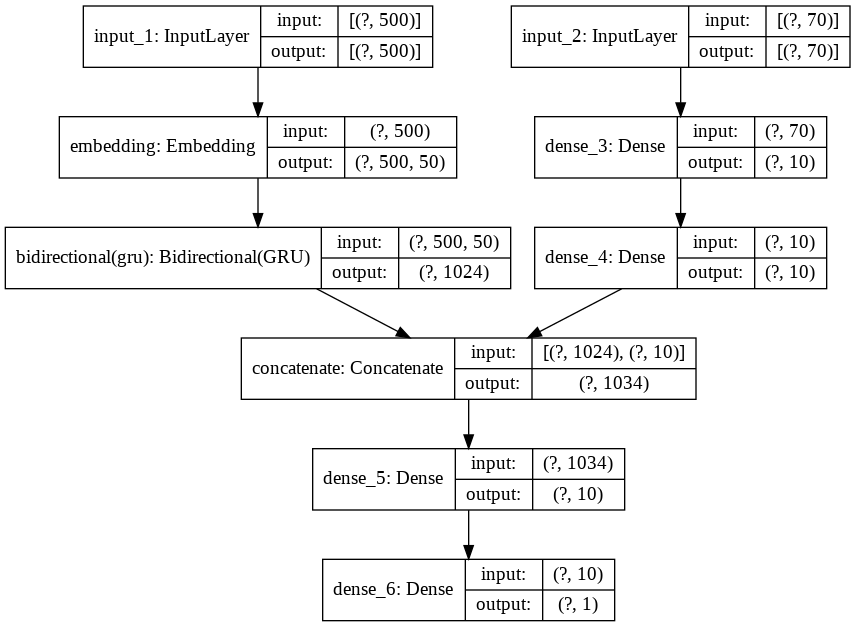

In [64]:
# Let us again display the model architecture
from keras.utils import plot_model
plot_model(model, to_file='model_plotfull.png', show_shapes=True, show_layer_names=True)

At the left branch, our text data are the input. Then an embedding layer follows. The hidden layer is a bidirectional GRU. At the right branch, we have the 70 non-textual features as input and two hidden layers. Both outputs get combined as the input for one last hidden layer, before the output layer and its linear regression generate the final output.

In [65]:
model_full_story = model.fit(x=[X_tr_int_pad, x_train1], y=y_train, validation_data=([X_ts_int_pad, x_test1], y_test), batch_size=128, epochs=30, verbose=1 , callbacks=[early])

Epoch 1/30
401/401 [==============================] - 130s 325ms/step - loss: 63.4586 - mse: 120945.7969 - val_loss: 67.2108 - val_mse: 43543.5859
Epoch 2/30
401/401 [==============================] - 128s 320ms/step - loss: 63.1895 - mse: 120514.2578 - val_loss: 66.4180 - val_mse: 43393.5117
Epoch 3/30
401/401 [==============================] - 128s 318ms/step - loss: 63.0550 - mse: 120369.4531 - val_loss: 66.0905 - val_mse: 43080.8477
Epoch 4/30
401/401 [==============================] - 127s 316ms/step - loss: 62.9704 - mse: 120309.6875 - val_loss: 66.1495 - val_mse: 43102.7969
Epoch 00004: early stopping


In [66]:
SCORE_BAG.update({'full' : eval(model, model_full_story, [X_ts_int_pad, x_test1], y_test)})

To evaluate the prediction, any common regression evaluation metric can be applied. We use mean absolute error (MAE).

In [67]:
SCORE_BAG

{'full': [66.14942932128906, 43102.80859375],
 'ofeatures': [67.50244903564453, 50127.31640625]}

Considering the additional time consumption, the improvement from the basic model to the model with word embeddings as input is rather modest.

# 4. Predictions

**4.1 Prepare dataset for predictions**

In [69]:
df_test = pd.read_csv(path + "Test.csv")

In [70]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          514 non-null    int64 
 1   index               514 non-null    int64 
 2   Author              514 non-null    object
 3   PublicationDetails  514 non-null    object
 4   Responses           432 non-null    object
 5   Header              506 non-null    object
 6   Text                514 non-null    object
 7   Length              514 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 32.2+ KB


The info function shows us that our dataset for the predictions has some missings. We will apply some simple data imputation methods.

In [71]:
#To do so, we first make use of regular expressions to change the features in a way that we can process them
df_test['Responses'] = df_test['Responses'].str.extract('(\d+)', expand=True)

In [72]:
df_test['Responses'] = pd.to_numeric(df_test['Responses'], errors='coerce')

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


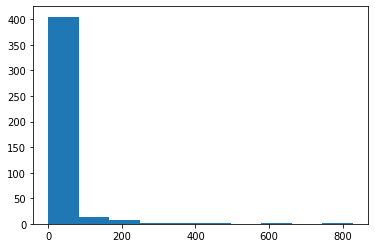

In [73]:
plt.hist(df_test.Responses)
plt.show()

In [74]:
#Based on the modus, we decide to impute NaNs with 0
#(alternative: a more elaborated way to impute the missings could be to use a simple model to predict the missings)
df_test['Responses']=df_test['Responses'].fillna(0)
df_test['responsesCreatedCount']=df_test['Responses']
df_test.drop(columns=['Responses'])

,Unnamed: 0,index,Author,PublicationDetails,Header,Text,Length,responsesCreatedCount
0,0,0,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 31, 2017",Why Everyone Missed the Most Mind-Blowing Feat...,There’s one incredible feature of cryptocurren...,23401,627.0
1,1,1,Noam Levenson,"Noam Levenson in HackerNoon.comDec 6, 2017",NEO versus Ethereum: Why NEO might be 2018’s s...,"<img class=""progressiveMedia-noscript js-progr...",23972,156.0
2,2,2,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 21, 2017",The Cryptocurrency Trading Bible,So you want to trade cryptocurrency?You’ve see...,402,176.0
3,3,5,Haseeb Qureshi,"Haseeb Qureshi in HackerNoon.comFeb 19, 2018",Stablecoins: designing a price-stable cryptocu...,A useful currency should be a medium of exchan...,19730,72.0
4,4,7,William Belk,"William Belk in HackerNoon.comJan 28, 2018",Chaos vs. Order — The Cryptocurrency Dilemma,Crypto crypto crypto crypto. It’s here. It’s h...,5324,19.0
...,...,...,...,...,...,...,...,...
509,509,598,"Jun 9, 2016","Tim Romero in Startup Lessons LearnedJun 9, 2016","Why I turned down $500K, Pissed off my investo...",I just did what no startup founder is ever sup...,9025,181.0
510,510,599,"Jun 10, 2016","Product HuntJun 10, 2016",These Tools Will Help You Launch Your Startup,If you’re embarking on the startup journey and...,5571,24.0
511,511,600,Mar-19,Joe ProcopioMar 19,Why Startups Fall Apart at 50 Employees,Fuck you startups with your extravagant partie...,475,24.0
512,512,601,"Mar 18, 2016","Winerist in Be YourselfMar 18, 2016",Beware of Startup Prostitution,Note: This is not a post to glorify prostituti...,13483,116.0


In [75]:
df_test['Date'] = df_test['PublicationDetails'].str.extract('(.{3}\s+.{1,2},\s+.{4}|.{3}\s+\d+)', expand=True)

In [76]:
df_test['Date'] = pd.to_datetime(df_test.Date, errors = 'coerce')
df_test['Date'] = df_test['Date'].dt.strftime('%Y-%m-%d')

In [77]:
import datetime
from datetime import datetime

now = datetime.now()
A = (now.strftime("%Y-%m-%d"))
date_format = "%Y-%m-%d"
A = datetime.strptime(A, date_format)
df_test['A']=A
df_test['Date']= pd.to_datetime(df_test['Date'])
df_test['daysonline'] = df_test['A']- df_test['Date']
df_test['daysonline'] = pd.to_numeric(df_test['daysonline'].dt.days, downcast='integer')

In [78]:
df_test['daysonline']=df_test['daysonline'].fillna(df_test['daysonline'].median())

In [79]:
df_test['weekday']= df_test['Date'].apply(lambda x: x.weekday())

In [80]:
df_test['weekday']=df_test['weekday'].fillna(0)

In [81]:
df_test['weekday'].value_counts()

0.0    162
2.0     88
1.0     83
3.0     81
4.0     68
5.0     19
6.0     13
Name: weekday, dtype: int64

In [82]:
df_test['weekday']=(df_test['weekday'].apply(lambda x: int(x)))

In [83]:
df_test['weekday'] = df_test['weekday'].astype('category',copy=False)

In [84]:
df_test['PublicationDetails']=df_test['PublicationDetails'].str.split('(.{3}\s+.{1,2},\s+.{4}|.{3}\s+\d+)').str[0]

In [85]:
df_test.head()

,Unnamed: 0,index,Author,PublicationDetails,Responses,Header,Text,Length,responsesCreatedCount,Date,A,daysonline,weekday
0,0,0,Daniel Jeffries,Daniel Jeffries in HackerNoon.com,627.0,Why Everyone Missed the Most Mind-Blowing Feat...,There’s one incredible feature of cryptocurren...,23401,627.0,2017-07-31,2020-08-26,1122.0,0
1,1,1,Noam Levenson,Noam Levenson in HackerNoon.com,156.0,NEO versus Ethereum: Why NEO might be 2018’s s...,"<img class=""progressiveMedia-noscript js-progr...",23972,156.0,2017-12-06,2020-08-26,994.0,2
2,2,2,Daniel Jeffries,Daniel Jeffries in HackerNoon.com,176.0,The Cryptocurrency Trading Bible,So you want to trade cryptocurrency?You’ve see...,402,176.0,2017-07-21,2020-08-26,1132.0,4
3,3,5,Haseeb Qureshi,Haseeb Qureshi in HackerNoon.com,72.0,Stablecoins: designing a price-stable cryptocu...,A useful currency should be a medium of exchan...,19730,72.0,2018-02-19,2020-08-26,919.0,0
4,4,7,William Belk,William Belk in HackerNoon.com,19.0,Chaos vs. Order — The Cryptocurrency Dilemma,Crypto crypto crypto crypto. It’s here. It’s h...,5324,19.0,2018-01-28,2020-08-26,941.0,6


In [86]:
df_test['publicationname']=df_test['PublicationDetails'].str.split('in ').str[1]

In [87]:
df_test['publicationname'].value_counts()[:10]

Netflix TechBlog        175
TE-FOOD                  34
HackerNoon.com           21
The Startup              20
freeCodeCamp.org         15
One Table, One World      9
The Billfold              5
Tank                      4
The Future Market         4
The Lily                  4
Name: publicationname, dtype: int64

In [88]:
#We manually checked if names were written differently in the training set than in our test set for prediction. To do this manually is definitely
#not the best way to do so due to its error rate
df_test['publicationname'].replace({'HackerNoon.com': 'Hacker Noon'}, inplace=True)

In [89]:
#Filling the missing Headers with the first words of the available text. To do so, we first figgure out how long titles are
df_test['titleWordCount'] = df_test['Header'].str.findall(r'(\w+)').str.len()
df_test['titleWordCount'].median()

8.0

In [90]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
df_test['titAlter']=df_test['Text'].str.split(' ').str[0:7] #the first 8 words
df_test['titAlter']=df_test['titAlter'].apply(lambda x: TreebankWordDetokenizer().detokenize(x))
df_test['Header']=df_test['Header'].fillna(df_test['titAlter'])
df_test['Header'].iloc[125:130]
#there might be a smoother one-line solution

125    Show Us Your Grocery Receipts, Part One: Whole...
126                            The sweetgreen Food Ethos
127                           The FoodChain Has Launched
128               So you’re thinking of growing your own
129    Why Restaurants Buy Impossible: An Inside Sale...
Name: Header, dtype: object

In [91]:
#creating our len variables
df_test['len_text'] = df_test['Text'].str.len()
df_test['len_title'] = df_test['Header'].str.len()

In [92]:
#In our training set we have the variable 'wordCount' provided. There are pros and cons to use this variable as alternative to len_text.
#Pro: When training the model with both alternatives, wordCount turned out to be more valuable.
#Cons: We do not know based on which text version (after cleaning or not) the original variable wordCount was created
#(- unfortunately due to lack of RAM my system crashes when trying to reproduce this variable)
df_test['wordCount'] = df_test['Text'].str.findall(r'(\w+)').str.len()
df_test['wordCount'].mean()
df['wordCount'].mean()
#I was tempted to stick to wordCount. However, the mean between wordCount of our training dataset and our prediction dataset differs so much, we decide it is the safer approach to make use of len_text instead of wordCount.

895.07666015625

In [93]:
df_test['imageCount'] = df_test.Text.str.findall('<img [^>]*src="([^"]+)').apply(len)

In [94]:
df_test['text_short'] = df_test['Text'].astype(str).apply(lambda x: x[:5000])

In [95]:
# Lemmatize with POS Tag
def get_wordnet_pos(word):
    """Map POS tag to first character for lemmatization"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [96]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [97]:
# this code is adapted from Lessmann (2020b)
def clean_text(df):
    """ Standard NLP pre-processing chain including removal of html tags, non-alphanumeric characters, and stopwords.
        Words are subject to lemmatization using their POS tags, which are determind using WordNet. 
    """
    articles = []

    lemmatizer = WordNetLemmatizer()
    
    print('*' * 40)
    print('Cleaning {} text/title.'.format(df.shape[0]))
    counter = 0
    for article in df:
        
        # remove html content
        article_text = BeautifulSoup(article).get_text()
        
        # remove non-alphabetic characters
        article_text = re.sub("[^a-zA-Z]"," ", article_text)
    
        # tokenize the sentences
        words = word_tokenize(article_text.lower())
  
        # filter stopwords
        words = [w for w in words if w not in stopwords.words("english")]
        
        # lemmatize each word to its lemma
        lemma_words =[lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in words]
    
        articles.append(lemma_words)
              
        if (counter > 0 and counter % 20 == 0):
            print('Processed {} text/titles'.format(counter))
            
        counter += 1
        
    print('DONE')
    print('*' * 40)

    return(articles) 

In [98]:
import nltk
nltk.download('averaged_perceptron_tagger')
# Do the cleaning
Text = clean_text(df_test.text_short)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
****************************************
Cleaning 514 text/title.
Processed 20 text/titles
Processed 40 text/titles
Processed 60 text/titles
Processed 80 text/titles
Processed 100 text/titles
Processed 120 text/titles
Processed 140 text/titles
Processed 160 text/titles
Processed 180 text/titles
Processed 200 text/titles
Processed 220 text/titles
Processed 240 text/titles
Processed 260 text/titles
Processed 280 text/titles
Processed 300 text/titles
Processed 320 text/titles
Processed 340 text/titles
Processed 360 text/titles
Processed 380 text/titles
Processed 400 text/titles
Processed 420 text/titles
Processed 440 text/titles
Processed 460 text/titles
Processed 480 text/titles
Processed 500 text/titles
DONE
****************************************


In [99]:
Title = clean_text(df_test.Header)

****************************************
Cleaning 514 text/title.
Processed 20 text/titles
Processed 40 text/titles
Processed 60 text/titles
Processed 80 text/titles
Processed 100 text/titles
Processed 120 text/titles
Processed 140 text/titles
Processed 160 text/titles
Processed 180 text/titles
Processed 200 text/titles
Processed 220 text/titles
Processed 240 text/titles
Processed 260 text/titles
Processed 280 text/titles
Processed 300 text/titles
Processed 320 text/titles
Processed 340 text/titles
Processed 360 text/titles
Processed 380 text/titles
Processed 400 text/titles
Processed 420 text/titles
Processed 440 text/titles
Processed 460 text/titles
Processed 480 text/titles
Processed 500 text/titles
DONE
****************************************


In [100]:
# Undo the tokenization and put the data into a new column in the data frame.
from nltk.tokenize.treebank import TreebankWordDetokenizer

df_test['text'] = [TreebankWordDetokenizer().detokenize(word) for word in Text]
df_test['title'] = [TreebankWordDetokenizer().detokenize(wrd) for wrd in Title]

In [101]:
!pip install langdetect
import langdetect
from langdetect import detect #I wanted to know how well this imported function works. See Appendix 6 for a test I conducted on the training dataset.
df_test['language'] = df_test['Header'].apply(detect)
df_test['language'].value_counts() #We have decided against a dummy for English articles only when training and, instead, limited the training set to English acrticles only.
#Unfortunately, therefore, the predictions for the few articles which are not in English will be less precise.

     |████████████████████████████████| 983kB 9.5MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=347de53e83d941ad10e380ac46106939cd2546638b80ed825c37097869adf833
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


en    491
de      5
ca      4
nl      3
ro      2
no      2
af      2
it      2
id      1
fi      1
ja      1
Name: language, dtype: int64

In [102]:
#SENTIMENT ANALYSER
from textblob import TextBlob
# Defining a sentiment analyser function
def sentiment_analyser(text):
    return text.apply(lambda Text: pd.Series(TextBlob(Text).sentiment.polarity))

df_test['Polarity'] = sentiment_analyser(df_test['text'])

In [103]:
## Count occurence of top fiveteen words in every title in dataframe
df_test['top_title_count'] = df_test['title'].apply(lambda s: sum(s.count(top_title_words[i]) for  i in range(15)))
df_test['top_text_count'] = df_test['text'].apply(lambda s: sum(s.count(top_text_words[i]) for  i in range(15)))

In [104]:
#TOPIC MODELING
text_df_test = pd.DataFrame(df_test.text)
text_df_test.columns = ['text']
df_test_wtv = wtv_vect.transform(text_df_test.text)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [105]:
y_km_df_test = km.predict(df_test_wtv)
print(df_test_wtv.shape)

km_df_test_pred = pd.DataFrame({'text' :text_df_test.text, 'topic_cluster' :y_km_df_test })

(514, 100)


In [106]:
df_test['topic_w2v']=km_df_test_pred['topic_cluster']

In [76]:
df_test.head()

,Unnamed: 0,index,Author,PublicationDetails,Responses,Header,Text,Length,responsesCreatedCount,Date,A,daysonline,weekday,publicationname,titleWordCount,titAlter,len_text,len_title,wordCount,imageCount,text_short,text,title,language,Polarity,top_title_count,top_text_count,topic_w2v
0,0,0,Daniel Jeffries,Daniel Jeffries in HackerNoon.com,627.0,Why Everyone Missed the Most Mind-Blowing Feat...,There’s one incredible feature of cryptocurren...,23401,627.0,2017-07-31,2020-08-25,1121.0,0,Hacker Noon,10.0,There’s one incredible feature of cryptocurren...,23401,67,4092,10,There’s one incredible feature of cryptocurren...,one incredible feature cryptocurrencies almost...,everyone miss mind blowing feature cryptocurrency,en,0.104543,0,50,3
1,1,1,Noam Levenson,Noam Levenson in HackerNoon.com,156.0,NEO versus Ethereum: Why NEO might be 2018’s s...,"<img class=""progressiveMedia-noscript js-progr...",23972,156.0,2017-12-06,2020-08-25,993.0,2,Hacker Noon,11.0,"<img class=""progressiveMedia-noscript js-progr...",23972,69,3902,9,"<img class=""progressiveMedia-noscript js-progr...",onchainneo founder da hongfei erik zhang found...,neo versus ethereum neo might strong cryptocur...,en,0.158771,0,59,4
2,2,2,Daniel Jeffries,Daniel Jeffries in HackerNoon.com,176.0,The Cryptocurrency Trading Bible,So you want to trade cryptocurrency?You’ve see...,402,176.0,2017-07-21,2020-08-25,1131.0,4,Hacker Noon,4.0,So you want to trade cryptocurrency?You’ve seen,402,32,80,0,So you want to trade cryptocurrency?You’ve see...,want trade cryptocurrency see eye pop return w...,cryptocurrency trading bible,en,0.010298,0,2,3
3,3,5,Haseeb Qureshi,Haseeb Qureshi in HackerNoon.com,72.0,Stablecoins: designing a price-stable cryptocu...,A useful currency should be a medium of exchan...,19730,72.0,2018-02-19,2020-08-25,918.0,0,Hacker Noon,6.0,A useful currency should be a medium,19730,52,3277,7,A useful currency should be a medium of exchan...,useful currency medium exchange unit account s...,stablecoins design price stable cryptocurrency,en,0.035018,0,35,3
4,4,7,William Belk,William Belk in HackerNoon.com,19.0,Chaos vs. Order — The Cryptocurrency Dilemma,Crypto crypto crypto crypto. It’s here. It’s h...,5324,19.0,2018-01-28,2020-08-25,940.0,6,Hacker Noon,6.0,Crypto crypto crypto crypto. It’s here. It’s,5324,44,860,0,Crypto crypto crypto crypto. It’s here. It’s h...,crypto crypto crypto crypto happen big way fas...,chaos v order cryptocurrency dilemma,en,0.112925,0,30,4


**4.2 Prediction and submission preparation**

In [107]:
df_test1=df_test[['responsesCreatedCount', 'len_text', 'imageCount', 'len_title','daysonline', 'weekday', 'top_title_count', 'top_text_count', 'publicationname', 'Polarity', 'topic_w2v']]

In [108]:
cat_columns = ['topic_w2v',  'publicationname','weekday']

We create the dummies in the test set based on the dummies of the training set.

In [109]:
df_test1 = pd.get_dummies(df_test1, prefix_sep="__", 
                                   columns=cat_columns)

In [110]:
# Remove additional columns
for col in df_test1.columns:
    if ("__" in col) and (col.split("__")[0] in cat_columns) and col not in cat_dummies:
        print("Removing additional feature {}".format(col))
        df_test1.drop(col, axis=1, inplace=True)

Removing additional feature publicationname__
Removing additional feature publicationname__ABUNDANCE INSIGHTS
Removing additional feature publicationname__Accelerated Intelligence
Removing additional feature publicationname__Age of Awareness
Removing additional feature publicationname__Anthemis Insights
Removing additional feature publicationname__ArcNews by Esri
Removing additional feature publicationname__BULLY KING Magazine
Removing additional feature publicationname__Backchannel
Removing additional feature publicationname__Be Yourself
Removing additional feature publicationname__BlockChannel
Removing additional feature publicationname__Circulate News
Removing additional feature publicationname__Code Like A Girl
Removing additional feature publicationname__Cognitive Dissident
Removing additional feature publicationname__Cosmos Blog
Removing additional feature publicationname__Design @ DoorDash
Removing additional feature publicationname__Dialogue & Discourse
Removing additional feat

In [111]:
for col in cat_dummies:
    if col not in df_test1.columns:
        print("Adding missing feature {}".format(col))
        df_test1[col] = 0

Adding missing feature topic_w2v__2
Adding missing feature publicationname__AI Hawk
Adding missing feature publicationname__ARCHITECHT
Adding missing feature publicationname__Advanced Design for Artificial Intelligence
Adding missing feature publicationname__All Turtles
Adding missing feature publicationname__Analytics Vidhya
Adding missing feature publicationname__Applied Artificial Intelligence
Adding missing feature publicationname__Becoming Human: Artificial Intelligence Magazine
Adding missing feature publicationname__Bottos
Adding missing feature publicationname__Budding Data Scientists
Adding missing feature publicationname__Cambridge Spark
Adding missing feature publicationname__Center for Data Science
Adding missing feature publicationname__Chatbot News Daily
Adding missing feature publicationname__Chatbots Life
Adding missing feature publicationname__Chatbots Magazine
Adding missing feature publicationname__Coinmonks
Adding missing feature publicationname__Cortex Labs
Adding 

Next, we standardize all features with StandardScaler(). The mean of each variable is subtracted and the values are divided by the standard deviation.
Standardization is important since the NN-models are sensitive to unstandardized features.


In [112]:
from sklearn.preprocessing import StandardScaler
df_test1= scaler.transform(df_test1)
 

In [113]:
# Encode and pad the test prediction data
MAX_ARTICLE_LENGTH = 500
df_ts_int = tokenizer_obj.texts_to_sequences(df_test.text) 
df_ts_int_pad = pad_sequences(df_ts_int, MAX_ARTICLE_LENGTH)

In [114]:
#Prepare submission
# make predictions on the testing data
preds = model.predict([df_ts_int_pad , df_test1])

In [115]:
preds

array([[ 4.19413008e+04],
       [ 1.03883750e+04],
       [ 1.14632080e+04],
       [ 4.43327881e+03],
       [ 8.91725220e+02],
       [ 1.38721912e+03],
       [ 4.42568359e+03],
       [ 1.62483899e+03],
       [ 2.98599072e+03],
       [ 1.11176880e+02],
       [ 3.50136749e+02],
       [ 6.24553467e+02],
       [ 2.36049160e+04],
       [ 2.14813496e+04],
       [ 4.12390747e+01],
       [ 4.40365631e+02],
       [ 3.98649559e+01],
       [ 2.61532867e+02],
       [ 2.52885300e+02],
       [ 1.11303528e+03],
       [ 8.86600876e+01],
       [ 3.89174774e+02],
       [ 2.22472275e+02],
       [ 7.51245264e+03],
       [ 6.96624805e+03],
       [ 4.94316650e+03],
       [ 7.54857764e+03],
       [ 3.23119653e+03],
       [ 4.44999902e+03],
       [ 2.11718213e+03],
       [ 1.31239575e+03],
       [ 2.07761914e+03],
       [ 1.01837195e+03],
       [ 1.74417944e+03],
       [ 1.36278455e+03],
       [ 4.97752899e+02],
       [ 6.70499329e+02],
       [ 9.60716736e+02],
       [ 8.2

In [123]:
preds [preds<0] = 0 #since there are no negative Claps

In [124]:
predictions = pd.DataFrame (preds, columns = ['preds'])


In [126]:
submission = pd.DataFrame({ 'index': df_test.index.values, 'Claps': predictions['preds'] })
# Store dataframe to disk
file_name = 'submission.pkl'
submission.to_pickle(path + file_name)


In [129]:
submission.to_csv("submission_Fluhrer.csv", index=False)
from google.colab import files
files.download("submission_Fluhrer.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 5. Conclusion


We tried to predict with Deep Learning the *Claps* an article receives. Additional to preparation and preprocessing of non-textual data, we applied numerous NLP techniques to clean and preprocess text. By working with regular expressions and applying topic modeling strategies and other elaborated NLP approaches, we generated a variety of additional features from our text data. We built models with different types of input. Our final model was able to process word embeddings and meta features as input. We successfully applied our final model to make predictions for our test set.

However, text feature extraction and building a precise Neural Network regression model is not a trivial task and, therefore, we finish this notebook with paying attentions to shortcomings of our procedure and possible ways to improve the estimation results:

1. Reduced text data
For the sake of saving computing time, we repeatedly shortened our text input and limited paramters. It could be worth a try to make use of the full text of the articles and apply word embeddings with additional dimensions.

2. Hyperparamter tuning
We only conducted hyperparamter tuning (batch size, epochs, learning rate, momentum, optimizer) for our basic model. In exchange for computing time, our final model could benefit from hyperparamter tuning.

3. Model architecture
It could be worth to try alternative architectures, e.g. making the NN deeper by adding additional hidden layers by at the same time taking care of the danger of overfitting. LSTM instead of GRU could improve the quality of the model as well.

4. OVV
We used pretrained GloVe embedding weights. The number of words which were not covered by the GloVe vocabulary was significant. We could apply techniques to reduce this number or apply another pretrained model, train our own word embedding model, or for instance try ELMo which uses character embeddings and therefore mitigates the OVV problem.

5. Target variable
In our training set, the majority of observations has 0 *Claps*. We considered log-transformation (not included in this notebook) but this went along with problems that we could not solve. An alternative could be trying to oversample observations with non-zero *Claps*.

All in all, this task comes along with endless possibilities; very often it is a trade-off between computing time and prediction capacity. We tried to provide a solution optimized regarding efficiency and learning effect.

# References

Goldberg, Y., & Levy, O. (2014). word2vec Explained: deriving Mikolov et al.'s negative-sampling word-embedding method. arXiv preprint arXiv:1402.3722.

Hsankesara (2018). Understanding Medium. *Kaggle*. URL
https://www.kaggle.com/hsankesara/understanding-medium.

Rong, X. (2014). word2vec parameter learning explained. arXiv preprint arXiv:1411.2738.

Lessmann, S. (2020a). Advanced Data Analytics for Management Support: Ex02_Pandas_and_EDA. Humboldt University, Berlin. Exercise.

Lessmann, S. (2020b). Advanced Data Analytics for Management Support: Ex11_sentiment_analysis. Humboldt University, Berlin. Exercise.

Usman, M. (2020). Python for NLP: Creating Multi-Data-Type Classification Models with Keras. *stackabuse*. URL https://stackabuse.com/python-for-nlp-creating-multi-data-type-classification-models-with-keras/.

Zhang, A. et al. (n.d.). Dive into Deep Learning. URL http://d2l.ai/index.html.

Zupan, J. (2003). Basics of artificial neural network. Nature-inspired Methods in Chemometrics: Genetic Algorithms and Artificial Neural Networks (Leardi, R., ed.), 199-229.

Wang, Z., Sugaya, S., & Nguyen, D. P. (2019). Salary Prediction using Bidirectional-GRU-CNN Model. Assoc. Nat. Lang. Process.

# Appendix


**Appendix 1: Latent Dirichlet Allocation (LDA)**

LDA is a Bayesian/probabilistic topic model.

LDA treats the text as a bag-of-words. The bag-of-words (BOW) model is a representation that turns text into fixed-length vectors with length equal to the vocabulary size.  Each dimension of this vector corresponds to the count or occurrence of a word in a document.

Since LDA ist based on BOW, we find that our approach is subject to the shortcomings of BOW. Metaphorically spoken, in a bag - the BOW - there is no order. Words loose contextual informations. The information where in a sentence and with which connotation a word appears gets lost. Moreover, in a bag it is dark which means with regards to our BOW, sematic relationships cannot be captured, for instance the use of synonyms (artifical intelligence aka machine intelligence), acronyms (e.g. machine learning aka ml) or homonyms.

!Credits: This part modified and applied code provided by https://www.kaggle.com/seanzhang1997/topic-modeling-lda-which-topic-has-more-claps

In [ ]:
count_vect = CountVectorizer(max_df=0.6,min_df=1)
# max_df is the maximum precentage this word show in the documents.
# Consequently, some words that appear in almost every text will be not considered
# min_df means at least it shows min_df times in the documents. Since our text is shortened, we keep this low
doc_term_matrix = count_vect.fit_transform(x_train["text"].values)
doc_term_matrix

In [ ]:
#create matrix for unseen test set
doc_term_matrix_test = count_vect.transform(x_test["text"].values)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
# LDA requires us to specify the number of topics.
number_topics = 7
number_words = 15
LDA = LatentDirichletAllocation(n_components=number_topics, n_jobs=-1)
LDA.fit(doc_term_matrix)
#A helper function to look into it
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
print("Topics:")
print_topics(LDA, count_vect, number_words)   

In [ ]:
!pip install pyLDAvis #visualizing LDA

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn
from pyLDAvis import sklearn as sklearn_lda
#prepare to display result in the notebook
pyLDAvis.enable_notebook()
LDAvis = sklearn_lda.prepare(LDA, doc_term_matrix, count_vect)
#run the visualization [mds is a function to use for visualizing the "distance" between topics]
LDAvis

In [ ]:
#Apply lda model and allocate articles into topics with the highest proportion
topic_values = LDA.transform(doc_term_matrix)
x_train['topic'] = topic_values.argmax(axis=1)

In [ ]:
#Apply lda model to unseen test data and allocate articles into topics with the highest proportion
topic_values_test = LDA.transform(doc_term_matrix_test)
x_test['topic'] = topic_values_test.argmax(axis=1)

In [ ]:
x_test['topic'].value_counts()

**Appendix 2: Reduced model without text features**

In [ ]:
x_train0=x_train[['responsesCreatedCount', 'len_text', 'imageCount', 'len_title','daysonline', 'top_title_count', 'top_text_count', 'publicationname', 'weekday','Polarity']]

x_test0=x_test[['responsesCreatedCount', 'len_text', 'imageCount','len_title','daysonline', 'top_title_count', 'top_text_count', 'publicationname', 'weekday', 'Polarity']]

In [ ]:
cat_columns = [ 'publicationname', 'weekday']

In [ ]:
x_train0 = pd.get_dummies(x_train0, prefix_sep="__",
                              columns=cat_columns)

We create the dummies in the test set based on the dummies of the training set.

In [ ]:
cat_dummies = [col for col in x_train0 
               if "__" in col 
               and col.split("__")[0] in cat_columns]

In [ ]:
x_test0 = pd.get_dummies(x_test0, prefix_sep="__", 
                                   columns=cat_columns)

In [ ]:
# Remove additional columns
for col in x_test0.columns:
    if ("__" in col) and (col.split("__")[0] in cat_columns) and col not in cat_dummies:
        print("Removing additional feature {}".format(col))
        x_test0.drop(col, axis=1, inplace=True)

In [ ]:
for col in cat_dummies:
    if col not in x_test0.columns:
        print("Adding missing feature {}".format(col))
        x_test0[col] = 0

Adding missing feature publicationname__Planeta Chatbot : todo sobre los Chatbots y la Inteligencia Artificial


Next, we standardize all features with StandardScaler().


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train0)#mind that we use only X_train values not to leak the data to the test set
x_train1= scaler.transform(x_train0)
x_test1= scaler.transform(x_test0) 

In [ ]:
dim=x_train0.shape[1]

In [ ]:
model_ofeatures = Sequential() #otherfeatures 
model_ofeatures.add(Dense(8, input_dim=dim, activation="relu")) #our non-linear activation function is relu
model_ofeatures.add(Dense(4, activation="relu"))
model_ofeatures.add(Dense(1, kernel_initializer='normal', activation='linear'))
model_ofeatures.compile(loss='mean_absolute_error', optimizer='adam') #adam optimization is used to update weights and biases
model_ofeatures.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 8)                 512       
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 553
Trainable params: 553
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_0_story = model_ofeatures.fit(x_train0, y_train, batch_size=BATCH_SIZE, epochs=EPOCH, validation_data=(x_test0, y_test), callbacks=[early])

Epoch 1/30
101/101 [==============================] - 1s 6ms/step - loss: 1.8850 - val_loss: 1.7357
Epoch 2/30
101/101 [==============================] - 0s 4ms/step - loss: 1.7223 - val_loss: 1.7396
Epoch 00002: early stopping


**Appendix 3: Hyperparamter Tuning - Basic Model**



In [ ]:
def create_model():
	# create model
 model = Sequential()
 model.add(Dense(32, input_dim=dim, activation="relu"))
 model.add(Dense(8, activation="relu"))
 model.add(Dense(1, kernel_initializer='normal', activation='linear'))
	# Compile model
 model.compile(loss='mean_absolute_error', optimizer='Adamax')
 return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=64, verbose=0)
# Let's define the grid search parameters
batchsize = [32, 64, 128, 256, 512]
epochs = [10,20,30]

#Set the grid
param_grid = dict(batch_size=batchsize, epochs=epochs)# setting a dictionary to store the results
param_grid 

{'batch_size': [32, 64, 128, 256, 512], 'epochs': [10, 30, 60]}

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1,cv=3, scoring='neg_mean_absolute_error')#parallelization, here using all processors
results = grid.fit(x_train1, y_train) #remember that we don't want to use the test set in CV
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: -1.935597 using {'batch_size': 32, 'epochs': 60}


In [ ]:
def create_model(optimizer='adam'):
# create model
 model = Sequential()
 model.add(Dense(32, input_dim=dim, activation="relu"))
 model.add(Dense(8, activation="relu"))
 model.add(Dense(1, kernel_initializer='normal', activation='linear'))
	# Compile model
 model.compile(loss='mean_absolute_error', optimizer=optimizer)
 return model

In [ ]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=60, batch_size=32, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=3)
grid_result = grid.fit(x_train1, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
from keras.optimizers import SGD
# Function to create model, required for KerasClassifier
def create_model(learn_rate=0.01, momentum=0):
	# create model
 model = Sequential()
 model.add(Dense(32, input_dim=dim, activation="relu"))
 model.add(Dense(8, activation="relu"))
 model.add(Dense(1, kernel_initializer='normal', activation='linear'))
	# Compile model
 optimizer = SGD(lr=learn_rate, momentum=momentum)
 model.compile(loss='mean_absolute_error', optimizer='Adamax')
 return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, epochs=60, batch_size=32, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=3)
grid_result = grid.fit(x_train1, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


**Appendix 4: Model comparison - Neural Network with embedding layer as input**

We create different Neural Network models and compare their results.
For this section code by Lessmann (2020b) was adapted and modified.

*Model 1: Basic Gated recurrent units (GRU) model*


In [ ]:
# Defining the embedding layer for our first model
embedding_layer=Embedding(input_dim=NUM_WORDS, 
                          output_dim=EMBEDDING_DIM, 
                          input_length=MAX_ARTICLE_LENGTH
                         )

model1 = Sequential()
model1.add(embedding_layer)
model1.add(GRU(units=64 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model1.add(Dense(units = 16 , activation = 'relu'))
model1.add(Dense(1, kernel_initializer='normal', activation='linear'))
model1.compile(loss='mean_absolute_error', optimizer='adam')
model1.summary()


In [ ]:
model1_story = model1.fit(X_tr_int_pad, y_train, batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=VAL_SPLIT)

val_loss is the value of cost function for our cross-validation data and loss is the value of cost function for your training data. 
The difference goes back to the drop out of random neurons in the validation data.

In [ ]:
SCORE_BAG = {}  # Dictionary to store the results of different Keras models
def eval (model, story, x_ts, y_ts, cut_off=0.5):
  score = model.evaluate(x_ts, y_ts, verbose=0)
  return score

In [ ]:
SCORE_BAG.update({'M1' : eval(model1, model1_story, X_ts_int_pad, y_test)})

*Model 2: GRU with pre-trained embeddings*



In [ ]:
# Embedding layer with the pre-trained GloVe weights
embedding_layer = Embedding(NUM_WORDS, 
                         EMBEDDING_DIM,  
                         embeddings_initializer=Constant(glove_weights), #pre-trained weights
                         input_length=MAX_ARTICLE_LENGTH, 
                         trainable=False
                         )

model2 = Sequential()
model2.add(embedding_layer)
model2.add(GRU(units=64 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25)) #We use drop out in order to add some noise to avoid over-fitting
model2.add(Dense(units = 16 , activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, kernel_initializer='normal', activation='linear'))
model2.compile(loss='mean_absolute_error', optimizer='adam')
model2.summary()

In [ ]:
# Train the model 
model2_story = model2.fit(X_tr_int_pad, y_train, batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=VAL_SPLIT)


to_disk = (model2, model2_story)
with open(path + 'model2.pkl','wb') as file_name:
    pickle.dump(to_disk, file_name)

In [ ]:
SCORE_BAG.update({'M2' : eval(model2, model2_story, X_ts_int_pad, y_test)})

*Model 3: Bidirectional GRU with pretrained embeddings*


In [ ]:
# Embedding layer with the pre-trained GloVe weights
embedding_layer = Embedding(NUM_WORDS, 
                         EMBEDDING_DIM,  
                         embeddings_initializer=Constant(glove_weights), 
                         input_length=MAX_ARTICLE_LENGTH, 
                         trainable=False 
                         )

model3 = Sequential()
model3.add(embedding_layer)
model3.add(Bidirectional(GRU(units=64 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25), merge_mode="concat"))
model3.add(Dense(units = 16 , activation = 'relu'))
model3.add(Dense(1, kernel_initializer='normal', activation='linear'))
model3.compile(loss='mean_absolute_error', optimizer='adam')
model3.summary()

In [ ]:
# Train the model 
model3_story = model3.fit(X_tr_int_pad, y_train, batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=VAL_SPLIT)


In [ ]:
SCORE_BAG.update({'M3' : eval(model3, model3_story, X_ts_int_pad, y_test)})

**Appendix 5: Compute embedding coverage rate of the pretrained GloVe embedding**

In [ ]:
glove = '/content/drive/My Drive/ADAMS_NLPtask_SS20/ADAMS_NLPtask_SS20/glove.twitter.27B.200d.txt'

In [ ]:
print("Extracting GloVe embedding")
embed_glove = load_embed(glove)

In [ ]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [ ]:
def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.3%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [ ]:
vocab = build_vocab(df['text'])

In [ ]:
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)

**Apppendix 6: Testing accurancy of the method language detect**

In [ ]:
df['language_detect'] = df['title'].apply(detect)

In [ ]:
comparison_column = np.where(df["language"] == df["language_detect"], True, False)
sum(comparison_column)/len(df) #percentage of correctly detected languages --- we could use text to get a better detection rate
#Be aware that we do not know how the feature language was generated in the training set. Maybe it was generated with the detect method; in this case
#our test does not say much about the accurancy of the method